In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# ============= Import required packaages ==============
import glob

# Import all custom variables and modules
from custom_classes_defs.setup import *
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   

#from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 1024
EPOCH_SIZE = 100
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

#from tensorflow.data import Dataset as tf_data
#import tensorflow.data as tf_data
# -------------------------------------------------------

2024-04-26 16:21:24.167355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 16:21:24.167423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 16:21:24.243608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 16:21:24.347352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data preparation and model configurations

---------------

In [4]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Fri Apr 26 16:21:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA A100 80GB PCIe          Off | 00000000:01:00.0 Off |                    0 |
| N/A   31C    P0              42W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80GB PCIe          Off | 00000000:41:00.0 Off |                    0 |
| N/A   31C    P0              43W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA A100 80GB PCIe          Off | 00000000:61:00.0 Off |                    0 |
| N/A   55C    P0             252W / 300W |  79551MiB / 81920MiB |    100%      Default |
|                                         |                      |             Disabled |
+---------

|   4  NVIDIA A100 80GB PCIe          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   29C    P0              43W / 300W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   5  NVIDIA A100 80GB PCIe          Off | 00000000:E1:00.0 Off |                    0 |
| N/A   30C    P0              42W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

In [5]:
# Input data path
seis_path = '../data_input/processed_patches/seismic/'
label_path = '../data_input/processed_patches/fault/'


In [6]:
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train')
val_dataset = thebe_data.data_generator(sub_group='val',as_numpy=True)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True)

2024-04-26 16:45:05.198868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-04-26 16:45:05.200621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79086 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0


In [7]:
# Model configurations
conf = model_config(
    epochs=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    scaling=1,
    verbose=1,
    save_path='../data_input/processed_patches/output/',
    img_shape=(96,96),
    target_size=(96,96),
    #augmentation = True,
    new_training_session=True,
    multiple_gpu_device=None
)


callbacks=conf.callbacks()
conf.set(validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    loss="binary_crossentropy",
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 100
                    batch_size: 1024
                       shuffle: False
                       verbose: 1
               validation_data: (array([[[0.43475017, 0.43047902, 0.41841674, ..., 0.4797052 ,
         0.47815222, 0.47515443],
        [0.43544173, 0.4398403 , 0.42669326, ..., 0.5111937 ,
         0.49692014, 0.49046198],
        [0.45614284, 0.4597261 , 0.45662764, ..., 0.50269693,
         0.49532002, 0.48994341],
        ...,
        [0.43000197, 0.4277162 , 0.4340627 , ..., 0.43319994,
         0.429754  , 0.42554367],
        [0.43525943, 0.43287677, 0.43895414, ..., 0.46002254,
         0.45060843, 0.44782078],
        [0.45203474, 0.45230177, 0.4585274 , ..., 0.47467837,
         0.46747687, 0.4650468 ]],

       [[0.4827918 , 0.4893142 , 0.5047952 , ..., 0.47215

### Build  model 

In [8]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

# model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,057,825
Total trainable wieghts: 2,054,049
Total non-trainable wieghts: 3,776


### Train and evaluate  model



	Train unet model
-------------------------------------------------------
Model training...


Epoch 1/100


2024-04-26 17:04:20.901650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-04-26 17:04:33.054157: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feadddabe30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 17:04:33.054221: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-26 17:04:33.054229: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-26 17:04:33.099790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1714143873.378368 1550609 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/177 [..............................] - ETA: 1:30:20 - loss: 2.0449 - accuracy: 0.3521

  2/177 [..............................] - ETA: 50s - loss: 2.3545 - accuracy: 0.5710    

  3/177 [..............................] - ETA: 46s - loss: 2.2062 - accuracy: 0.6688

  4/177 [..............................] - ETA: 45s - loss: 2.0718 - accuracy: 0.7245

  5/177 [..............................] - ETA: 44s - loss: 1.9824 - accuracy: 0.7585

  6/177 [>.............................] - ETA: 44s - loss: 1.9228 - accuracy: 0.7810

  7/177 [>.............................] - ETA: 44s - loss: 1.8734 - accuracy: 0.7970

  8/177 [>.............................] - ETA: 43s - loss: 1.8450 - accuracy: 0.8045

  9/177 [>.............................] - ETA: 43s - loss: 1.8034 - accuracy: 0.8132

 10/177 [>.............................] - ETA: 43s - loss: 1.7704 - accuracy: 0.8213

 11/177 [>.............................] - ETA: 42s - loss: 1.7331 - accuracy: 0.8279

 12/177 [=>............................] - ETA: 42s - loss: 1.7128 - accuracy: 0.8236

 13/177 [=>............................] - ETA: 42s - loss: 1.6814 - accuracy: 0.8290

 14/177 [=>............................] - ETA: 41s - loss: 1.6597 - accuracy: 0.8336

 15/177 [=>............................] - ETA: 41s - loss: 1.6346 - accuracy: 0.8376

 16/177 [=>............................] - ETA: 41s - loss: 1.6019 - accuracy: 0.8406

 17/177 [=>............................] - ETA: 40s - loss: 1.5808 - accuracy: 0.8338

 18/177 [==>...........................] - ETA: 40s - loss: 1.5493 - accuracy: 0.8344

 19/177 [==>...........................] - ETA: 40s - loss: 1.5200 - accuracy: 0.8374

 20/177 [==>...........................] - ETA: 40s - loss: 1.4920 - accuracy: 0.8403

 21/177 [==>...........................] - ETA: 39s - loss: 1.4629 - accuracy: 0.8425

 22/177 [==>...........................] - ETA: 39s - loss: 1.4320 - accuracy: 0.8425

 23/177 [==>...........................] - ETA: 39s - loss: 1.4056 - accuracy: 0.8393

 24/177 [===>..........................] - ETA: 39s - loss: 1.3740 - accuracy: 0.8411

 25/177 [===>..........................] - ETA: 38s - loss: 1.3449 - accuracy: 0.8432

 26/177 [===>..........................] - ETA: 38s - loss: 1.3182 - accuracy: 0.8451

 27/177 [===>..........................] - ETA: 38s - loss: 1.2911 - accuracy: 0.8468

 28/177 [===>..........................] - ETA: 38s - loss: 1.2652 - accuracy: 0.8480

 29/177 [===>..........................] - ETA: 37s - loss: 1.2409 - accuracy: 0.8485

 30/177 [====>.........................] - ETA: 37s - loss: 1.2175 - accuracy: 0.8490

 31/177 [====>.........................] - ETA: 37s - loss: 1.1940 - accuracy: 0.8501

 32/177 [====>.........................] - ETA: 37s - loss: 1.1727 - accuracy: 0.8511

 33/177 [====>.........................] - ETA: 36s - loss: 1.1513 - accuracy: 0.8519

 34/177 [====>.........................] - ETA: 36s - loss: 1.1310 - accuracy: 0.8517

 35/177 [====>.........................] - ETA: 36s - loss: 1.1111 - accuracy: 0.8527

 36/177 [=====>........................] - ETA: 35s - loss: 1.0927 - accuracy: 0.8538

 37/177 [=====>........................] - ETA: 35s - loss: 1.0743 - accuracy: 0.8549

 38/177 [=====>........................] - ETA: 35s - loss: 1.0564 - accuracy: 0.8555

 39/177 [=====>........................] - ETA: 35s - loss: 1.0395 - accuracy: 0.8558

 40/177 [=====>........................] - ETA: 34s - loss: 1.0237 - accuracy: 0.8568

 41/177 [=====>........................] - ETA: 34s - loss: 1.0094 - accuracy: 0.8576

 42/177 [======>.......................] - ETA: 34s - loss: 0.9952 - accuracy: 0.8585

 43/177 [======>.......................] - ETA: 34s - loss: 0.9810 - accuracy: 0.8592

 44/177 [======>.......................] - ETA: 33s - loss: 0.9694 - accuracy: 0.8584

 45/177 [======>.......................] - ETA: 33s - loss: 0.9568 - accuracy: 0.8592

 46/177 [======>.......................] - ETA: 33s - loss: 0.9464 - accuracy: 0.8599

 47/177 [======>.......................] - ETA: 33s - loss: 0.9370 - accuracy: 0.8606

 48/177 [=======>......................] - ETA: 32s - loss: 0.9276 - accuracy: 0.8612

 49/177 [=======>......................] - ETA: 32s - loss: 0.9177 - accuracy: 0.8619

 50/177 [=======>......................] - ETA: 32s - loss: 0.9073 - accuracy: 0.8624

 51/177 [=======>......................] - ETA: 32s - loss: 0.8974 - accuracy: 0.8626

 52/177 [=======>......................] - ETA: 31s - loss: 0.8882 - accuracy: 0.8624

 53/177 [=======>......................] - ETA: 31s - loss: 0.8784 - accuracy: 0.8629

 54/177 [========>.....................] - ETA: 31s - loss: 0.8696 - accuracy: 0.8634

 55/177 [========>.....................] - ETA: 31s - loss: 0.8611 - accuracy: 0.8640

 56/177 [========>.....................] - ETA: 30s - loss: 0.8530 - accuracy: 0.8645

 57/177 [========>.....................] - ETA: 30s - loss: 0.8446 - accuracy: 0.8650

 58/177 [========>.....................] - ETA: 30s - loss: 0.8366 - accuracy: 0.8652

 59/177 [=========>....................] - ETA: 30s - loss: 0.8290 - accuracy: 0.8654

 60/177 [=========>....................] - ETA: 29s - loss: 0.8212 - accuracy: 0.8658

 61/177 [=========>....................] - ETA: 29s - loss: 0.8136 - accuracy: 0.8663

 62/177 [=========>....................] - ETA: 29s - loss: 0.8065 - accuracy: 0.8667

 63/177 [=========>....................] - ETA: 29s - loss: 0.7995 - accuracy: 0.8671

 64/177 [=========>....................] - ETA: 28s - loss: 0.7929 - accuracy: 0.8672

 65/177 [==========>...................] - ETA: 28s - loss: 0.7863 - accuracy: 0.8676

 66/177 [==========>...................] - ETA: 28s - loss: 0.7799 - accuracy: 0.8679

 67/177 [==========>...................] - ETA: 28s - loss: 0.7737 - accuracy: 0.8683

 68/177 [==========>...................] - ETA: 27s - loss: 0.7675 - accuracy: 0.8687

 69/177 [==========>...................] - ETA: 27s - loss: 0.7616 - accuracy: 0.8690

 70/177 [==========>...................] - ETA: 27s - loss: 0.7560 - accuracy: 0.8692

 71/177 [===========>..................] - ETA: 27s - loss: 0.7504 - accuracy: 0.8695

 72/177 [===========>..................] - ETA: 26s - loss: 0.7448 - accuracy: 0.8698

 73/177 [===========>..................] - ETA: 26s - loss: 0.7394 - accuracy: 0.8701

 74/177 [===========>..................] - ETA: 26s - loss: 0.7341 - accuracy: 0.8704

 75/177 [===========>..................] - ETA: 26s - loss: 0.7291 - accuracy: 0.8707

 76/177 [===========>..................] - ETA: 25s - loss: 0.7242 - accuracy: 0.8709

 77/177 [============>.................] - ETA: 25s - loss: 0.7193 - accuracy: 0.8712

 78/177 [============>.................] - ETA: 25s - loss: 0.7146 - accuracy: 0.8714

 79/177 [============>.................] - ETA: 24s - loss: 0.7099 - accuracy: 0.8717

 80/177 [============>.................] - ETA: 24s - loss: 0.7054 - accuracy: 0.8720

 81/177 [============>.................] - ETA: 24s - loss: 0.7010 - accuracy: 0.8722

 82/177 [============>.................] - ETA: 24s - loss: 0.6967 - accuracy: 0.8724

 83/177 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.8726

 84/177 [=============>................] - ETA: 23s - loss: 0.6885 - accuracy: 0.8729

 85/177 [=============>................] - ETA: 23s - loss: 0.6845 - accuracy: 0.8731

 86/177 [=============>................] - ETA: 23s - loss: 0.6806 - accuracy: 0.8733

 87/177 [=============>................] - ETA: 22s - loss: 0.6767 - accuracy: 0.8735

 88/177 [=============>................] - ETA: 22s - loss: 0.6730 - accuracy: 0.8737

 89/177 [==============>...............] - ETA: 22s - loss: 0.6693 - accuracy: 0.8739

 90/177 [==============>...............] - ETA: 22s - loss: 0.6657 - accuracy: 0.8741

 91/177 [==============>...............] - ETA: 21s - loss: 0.6622 - accuracy: 0.8743

 92/177 [==============>...............] - ETA: 21s - loss: 0.6588 - accuracy: 0.8745

 93/177 [==============>...............] - ETA: 21s - loss: 0.6555 - accuracy: 0.8747

 94/177 [==============>...............] - ETA: 21s - loss: 0.6521 - accuracy: 0.8749

 95/177 [===============>..............] - ETA: 20s - loss: 0.6489 - accuracy: 0.8751

 96/177 [===============>..............] - ETA: 20s - loss: 0.6458 - accuracy: 0.8752

 97/177 [===============>..............] - ETA: 20s - loss: 0.6427 - accuracy: 0.8754

 98/177 [===============>..............] - ETA: 20s - loss: 0.6396 - accuracy: 0.8756

 99/177 [===============>..............] - ETA: 19s - loss: 0.6366 - accuracy: 0.8758

100/177 [===============>..............] - ETA: 19s - loss: 0.6336 - accuracy: 0.8760

101/177 [================>.............] - ETA: 19s - loss: 0.6308 - accuracy: 0.8761

102/177 [================>.............] - ETA: 19s - loss: 0.6280 - accuracy: 0.8763

103/177 [================>.............] - ETA: 18s - loss: 0.6252 - accuracy: 0.8765

104/177 [================>.............] - ETA: 18s - loss: 0.6226 - accuracy: 0.8766

105/177 [================>.............] - ETA: 18s - loss: 0.6199 - accuracy: 0.8768

106/177 [================>.............] - ETA: 18s - loss: 0.6173 - accuracy: 0.8769

107/177 [=================>............] - ETA: 17s - loss: 0.6148 - accuracy: 0.8770

108/177 [=================>............] - ETA: 17s - loss: 0.6123 - accuracy: 0.8772

109/177 [=================>............] - ETA: 17s - loss: 0.6098 - accuracy: 0.8773

110/177 [=================>............] - ETA: 17s - loss: 0.6075 - accuracy: 0.8774

111/177 [=================>............] - ETA: 16s - loss: 0.6051 - accuracy: 0.8775

112/177 [=================>............] - ETA: 16s - loss: 0.6028 - accuracy: 0.8777

113/177 [==================>...........] - ETA: 16s - loss: 0.6005 - accuracy: 0.8778

114/177 [==================>...........] - ETA: 16s - loss: 0.5983 - accuracy: 0.8780

115/177 [==================>...........] - ETA: 15s - loss: 0.5960 - accuracy: 0.8781

116/177 [==================>...........] - ETA: 15s - loss: 0.5939 - accuracy: 0.8782

117/177 [==================>...........] - ETA: 15s - loss: 0.5918 - accuracy: 0.8783

118/177 [===================>..........] - ETA: 15s - loss: 0.5897 - accuracy: 0.8784

119/177 [===================>..........] - ETA: 14s - loss: 0.5876 - accuracy: 0.8786

120/177 [===================>..........] - ETA: 14s - loss: 0.5856 - accuracy: 0.8787

121/177 [===================>..........] - ETA: 14s - loss: 0.5836 - accuracy: 0.8788

122/177 [===================>..........] - ETA: 14s - loss: 0.5816 - accuracy: 0.8789

123/177 [===================>..........] - ETA: 13s - loss: 0.5797 - accuracy: 0.8790

124/177 [====================>.........] - ETA: 13s - loss: 0.5778 - accuracy: 0.8791

125/177 [====================>.........] - ETA: 13s - loss: 0.5759 - accuracy: 0.8793

126/177 [====================>.........] - ETA: 12s - loss: 0.5741 - accuracy: 0.8794

127/177 [====================>.........] - ETA: 12s - loss: 0.5722 - accuracy: 0.8795

128/177 [====================>.........] - ETA: 12s - loss: 0.5704 - accuracy: 0.8796

129/177 [====================>.........] - ETA: 12s - loss: 0.5687 - accuracy: 0.8797

130/177 [=====================>........] - ETA: 11s - loss: 0.5669 - accuracy: 0.8798

131/177 [=====================>........] - ETA: 11s - loss: 0.5653 - accuracy: 0.8799

132/177 [=====================>........] - ETA: 11s - loss: 0.5636 - accuracy: 0.8800

133/177 [=====================>........] - ETA: 11s - loss: 0.5620 - accuracy: 0.8801

134/177 [=====================>........] - ETA: 10s - loss: 0.5604 - accuracy: 0.8802

135/177 [=====================>........] - ETA: 10s - loss: 0.5588 - accuracy: 0.8802

136/177 [======================>.......] - ETA: 10s - loss: 0.5572 - accuracy: 0.8803

137/177 [======================>.......] - ETA: 10s - loss: 0.5557 - accuracy: 0.8804

138/177 [======================>.......] - ETA: 9s - loss: 0.5542 - accuracy: 0.8805 

139/177 [======================>.......] - ETA: 9s - loss: 0.5528 - accuracy: 0.8806

140/177 [======================>.......] - ETA: 9s - loss: 0.5513 - accuracy: 0.8807

141/177 [======================>.......] - ETA: 9s - loss: 0.5498 - accuracy: 0.8807

142/177 [=======================>......] - ETA: 8s - loss: 0.5483 - accuracy: 0.8808

143/177 [=======================>......] - ETA: 8s - loss: 0.5469 - accuracy: 0.8809

144/177 [=======================>......] - ETA: 8s - loss: 0.5456 - accuracy: 0.8810

145/177 [=======================>......] - ETA: 8s - loss: 0.5442 - accuracy: 0.8811

146/177 [=======================>......] - ETA: 7s - loss: 0.5428 - accuracy: 0.8811

147/177 [=======================>......] - ETA: 7s - loss: 0.5415 - accuracy: 0.8812

148/177 [========================>.....] - ETA: 7s - loss: 0.5402 - accuracy: 0.8813

149/177 [========================>.....] - ETA: 7s - loss: 0.5389 - accuracy: 0.8813

150/177 [========================>.....] - ETA: 6s - loss: 0.5376 - accuracy: 0.8814

151/177 [========================>.....] - ETA: 6s - loss: 0.5363 - accuracy: 0.8815

152/177 [========================>.....] - ETA: 6s - loss: 0.5351 - accuracy: 0.8816

153/177 [========================>.....] - ETA: 6s - loss: 0.5338 - accuracy: 0.8817

154/177 [=========================>....] - ETA: 5s - loss: 0.5326 - accuracy: 0.8817

155/177 [=========================>....] - ETA: 5s - loss: 0.5314 - accuracy: 0.8818

156/177 [=========================>....] - ETA: 5s - loss: 0.5302 - accuracy: 0.8819

157/177 [=========================>....] - ETA: 5s - loss: 0.5291 - accuracy: 0.8819

158/177 [=========================>....] - ETA: 4s - loss: 0.5279 - accuracy: 0.8820

159/177 [=========================>....] - ETA: 4s - loss: 0.5267 - accuracy: 0.8821

160/177 [==========================>...] - ETA: 4s - loss: 0.5256 - accuracy: 0.8821

161/177 [==========================>...] - ETA: 4s - loss: 0.5245 - accuracy: 0.8822

162/177 [==========================>...] - ETA: 3s - loss: 0.5234 - accuracy: 0.8822

163/177 [==========================>...] - ETA: 3s - loss: 0.5223 - accuracy: 0.8823

164/177 [==========================>...] - ETA: 3s - loss: 0.5212 - accuracy: 0.8823

165/177 [==========================>...] - ETA: 3s - loss: 0.5201 - accuracy: 0.8824

166/177 [===========================>..] - ETA: 2s - loss: 0.5191 - accuracy: 0.8824

167/177 [===========================>..] - ETA: 2s - loss: 0.5181 - accuracy: 0.8825

168/177 [===========================>..] - ETA: 2s - loss: 0.5170 - accuracy: 0.8826

169/177 [===========================>..] - ETA: 2s - loss: 0.5160 - accuracy: 0.8826

170/177 [===========================>..] - ETA: 1s - loss: 0.5150 - accuracy: 0.8826

171/177 [===========================>..] - ETA: 1s - loss: 0.5141 - accuracy: 0.8827

172/177 [============================>.] - ETA: 1s - loss: 0.5131 - accuracy: 0.8827

173/177 [============================>.] - ETA: 1s - loss: 0.5121 - accuracy: 0.8828

174/177 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.8828

175/177 [============================>.] - ETA: 0s - loss: 0.5102 - accuracy: 0.8829

176/177 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.8830

177/177 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.8830

177/177 [==============================] - 101s 401ms/step - loss: 0.5085 - accuracy: 0.8830 - val_loss: 0.3658 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 2/100


  1/177 [..............................] - ETA: 45s - loss: 0.3400 - accuracy: 0.8938

  2/177 [..............................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8933

  3/177 [..............................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8934

  4/177 [..............................] - ETA: 43s - loss: 0.3421 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3415 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3414 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3416 - accuracy: 0.8932

  8/177 [>.............................] - ETA: 42s - loss: 0.3422 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3416 - accuracy: 0.8932

 10/177 [>.............................] - ETA: 42s - loss: 0.3413 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3410 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3409 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3406 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3406 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3406 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3406 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3408 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3407 - accuracy: 0.8936

 20/177 [==>...........................] - ETA: 40s - loss: 0.3405 - accuracy: 0.8937

 21/177 [==>...........................] - ETA: 39s - loss: 0.3404 - accuracy: 0.8937

 22/177 [==>...........................] - ETA: 39s - loss: 0.3406 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3407 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3408 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3408 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3409 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3409 - accuracy: 0.8935

 28/177 [===>..........................] - ETA: 38s - loss: 0.3409 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3410 - accuracy: 0.8934

 30/177 [====>.........................] - ETA: 37s - loss: 0.3411 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3410 - accuracy: 0.8934

 32/177 [====>.........................] - ETA: 37s - loss: 0.3412 - accuracy: 0.8933

 33/177 [====>.........................] - ETA: 36s - loss: 0.3414 - accuracy: 0.8932

 34/177 [====>.........................] - ETA: 36s - loss: 0.3415 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3415 - accuracy: 0.8932

 36/177 [=====>........................] - ETA: 36s - loss: 0.3414 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3413 - accuracy: 0.8933

 38/177 [=====>........................] - ETA: 35s - loss: 0.3413 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3412 - accuracy: 0.8933

 40/177 [=====>........................] - ETA: 34s - loss: 0.3412 - accuracy: 0.8933

 41/177 [=====>........................] - ETA: 34s - loss: 0.3413 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3413 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3413 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3414 - accuracy: 0.8932

 45/177 [======>.......................] - ETA: 33s - loss: 0.3414 - accuracy: 0.8932

 46/177 [======>.......................] - ETA: 33s - loss: 0.3414 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3415 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3416 - accuracy: 0.8931

 49/177 [=======>......................] - ETA: 32s - loss: 0.3416 - accuracy: 0.8931

 50/177 [=======>......................] - ETA: 32s - loss: 0.3416 - accuracy: 0.8931

 51/177 [=======>......................] - ETA: 32s - loss: 0.3416 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3415 - accuracy: 0.8931

 53/177 [=======>......................] - ETA: 31s - loss: 0.3415 - accuracy: 0.8931

 54/177 [========>.....................] - ETA: 31s - loss: 0.3416 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3417 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3417 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3416 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3417 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3418 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3417 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3418 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3418 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3418 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3418 - accuracy: 0.8929

 71/177 [===========>..................] - ETA: 27s - loss: 0.3418 - accuracy: 0.8929

 72/177 [===========>..................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3418 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3417 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3419 - accuracy: 0.8929

 76/177 [===========>..................] - ETA: 25s - loss: 0.3419 - accuracy: 0.8929

 77/177 [============>.................] - ETA: 25s - loss: 0.3418 - accuracy: 0.8929

 78/177 [============>.................] - ETA: 25s - loss: 0.3419 - accuracy: 0.8929

 79/177 [============>.................] - ETA: 25s - loss: 0.3419 - accuracy: 0.8929

 80/177 [============>.................] - ETA: 24s - loss: 0.3418 - accuracy: 0.8929

 81/177 [============>.................] - ETA: 24s - loss: 0.3418 - accuracy: 0.8929

 82/177 [============>.................] - ETA: 24s - loss: 0.3420 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3420 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3420 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8928

 86/177 [=============>................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8928

 88/177 [=============>................] - ETA: 22s - loss: 0.3421 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3421 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3422 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3421 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3421 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3421 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3421 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3421 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3422 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3421 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3421 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3422 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3422 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3422 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3422 - accuracy: 0.8927

111/177 [=================>............] - ETA: 16s - loss: 0.3422 - accuracy: 0.8927

112/177 [=================>............] - ETA: 16s - loss: 0.3422 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3422 - accuracy: 0.8927

114/177 [==================>...........] - ETA: 16s - loss: 0.3422 - accuracy: 0.8927

115/177 [==================>...........] - ETA: 15s - loss: 0.3422 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3422 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3422 - accuracy: 0.8927

118/177 [===================>..........] - ETA: 15s - loss: 0.3422 - accuracy: 0.8927

119/177 [===================>..........] - ETA: 14s - loss: 0.3422 - accuracy: 0.8927

120/177 [===================>..........] - ETA: 14s - loss: 0.3422 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3422 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3422 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3422 - accuracy: 0.8927

124/177 [====================>.........] - ETA: 13s - loss: 0.3422 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3421 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3421 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3421 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3421 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3421 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3421 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3421 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3421 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3421 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3420 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3421 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3421 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3421 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3421 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3421 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3421 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3421 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3421 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3421 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3421 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3421 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3421 - accuracy: 0.8927

150/177 [========================>.....] - ETA: 6s - loss: 0.3421 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3421 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3421 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3421 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3420 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3421 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3421 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3421 - accuracy: 0.8927

158/177 [=========================>....] - ETA: 4s - loss: 0.3421 - accuracy: 0.8927

159/177 [=========================>....] - ETA: 4s - loss: 0.3421 - accuracy: 0.8927

160/177 [==========================>...] - ETA: 4s - loss: 0.3422 - accuracy: 0.8927

161/177 [==========================>...] - ETA: 4s - loss: 0.3422 - accuracy: 0.8927

162/177 [==========================>...] - ETA: 3s - loss: 0.3422 - accuracy: 0.8927

163/177 [==========================>...] - ETA: 3s - loss: 0.3422 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3422 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3422 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3422 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3423 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3423 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3423 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3423 - accuracy: 0.8926

171/177 [===========================>..] - ETA: 1s - loss: 0.3424 - accuracy: 0.8926

172/177 [============================>.] - ETA: 1s - loss: 0.3424 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3424 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8926

177/177 [==============================] - 51s 291ms/step - loss: 0.3424 - accuracy: 0.8926 - val_loss: 0.3574 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 3/100


  1/177 [..............................] - ETA: 45s - loss: 0.3391 - accuracy: 0.8939

  2/177 [..............................] - ETA: 43s - loss: 0.3408 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3403 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3412 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3406 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3405 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3406 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3406 - accuracy: 0.8932

 10/177 [>.............................] - ETA: 42s - loss: 0.3403 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3400 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 41s - loss: 0.3399 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3396 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3396 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3396 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 40s - loss: 0.3396 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3398 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3398 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3397 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3395 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3394 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3396 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3397 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3398 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3398 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3399 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3399 - accuracy: 0.8935

 28/177 [===>..........................] - ETA: 37s - loss: 0.3399 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3400 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3401 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3401 - accuracy: 0.8934

 32/177 [====>.........................] - ETA: 36s - loss: 0.3403 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3405 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3405 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3405 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3404 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8933

 38/177 [=====>........................] - ETA: 35s - loss: 0.3404 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3404 - accuracy: 0.8933

 40/177 [=====>........................] - ETA: 34s - loss: 0.3403 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3405 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3404 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3404 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3405 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3406 - accuracy: 0.8932

 46/177 [======>.......................] - ETA: 33s - loss: 0.3406 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3408 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3408 - accuracy: 0.8931

 49/177 [=======>......................] - ETA: 32s - loss: 0.3408 - accuracy: 0.8931

 50/177 [=======>......................] - ETA: 32s - loss: 0.3408 - accuracy: 0.8931

 51/177 [=======>......................] - ETA: 32s - loss: 0.3409 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3408 - accuracy: 0.8931

 53/177 [=======>......................] - ETA: 31s - loss: 0.3408 - accuracy: 0.8931

 54/177 [========>.....................] - ETA: 31s - loss: 0.3409 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3410 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3410 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3409 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3410 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3411 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3411 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3412 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3411 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3412 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3412 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 26s - loss: 0.3412 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3412 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3411 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3411 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8929

 76/177 [===========>..................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8929

 77/177 [============>.................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3412 - accuracy: 0.8929

 79/177 [============>.................] - ETA: 24s - loss: 0.3412 - accuracy: 0.8929

 80/177 [============>.................] - ETA: 24s - loss: 0.3412 - accuracy: 0.8929

 81/177 [============>.................] - ETA: 24s - loss: 0.3412 - accuracy: 0.8929

 82/177 [============>.................] - ETA: 24s - loss: 0.3413 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8928

 86/177 [=============>................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8928

 88/177 [=============>................] - ETA: 22s - loss: 0.3415 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3415 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3415 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3415 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3416 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3416 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3415 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3415 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3415 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3415 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3415 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3415 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3414 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3415 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3414 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3414 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3415 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3415 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3415 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3415 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3415 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3415 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3415 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3416 - accuracy: 0.8927

112/177 [=================>............] - ETA: 16s - loss: 0.3415 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3416 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3415 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3415 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3415 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3416 - accuracy: 0.8927

118/177 [===================>..........] - ETA: 15s - loss: 0.3416 - accuracy: 0.8927

119/177 [===================>..........] - ETA: 14s - loss: 0.3416 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3415 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3415 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 13s - loss: 0.3415 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3416 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3415 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3415 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3415 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3414 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3415 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3415 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3415 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3414 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3415 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3415 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3415 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3415 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3415 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3415 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3415 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3415 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3415 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3415 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3415 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3415 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3415 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3415 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3415 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3414 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3415 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3415 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3415 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3415 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3415 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3415 - accuracy: 0.8927

161/177 [==========================>...] - ETA: 4s - loss: 0.3416 - accuracy: 0.8927

162/177 [==========================>...] - ETA: 3s - loss: 0.3416 - accuracy: 0.8927

163/177 [==========================>...] - ETA: 3s - loss: 0.3416 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3416 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3416 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3416 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3417 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3416 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3417 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3417 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3417 - accuracy: 0.8926

172/177 [============================>.] - ETA: 1s - loss: 0.3418 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3418 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8926

177/177 [==============================] - 51s 290ms/step - loss: 0.3418 - accuracy: 0.8926 - val_loss: 0.3530 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 4/100


  1/177 [..............................] - ETA: 45s - loss: 0.3389 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3406 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3410 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3403 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3402 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3403 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 42s - loss: 0.3408 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3403 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3400 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 41s - loss: 0.3397 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 41s - loss: 0.3395 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3393 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3393 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 40s - loss: 0.3393 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 40s - loss: 0.3393 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3395 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3395 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 39s - loss: 0.3394 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3392 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3393 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 38s - loss: 0.3394 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3395 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3395 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3396 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3397 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3397 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3398 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3398 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3400 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3402 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3402 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3402 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3402 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3400 - accuracy: 0.8933

 38/177 [=====>........................] - ETA: 35s - loss: 0.3401 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3401 - accuracy: 0.8933

 40/177 [=====>........................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3402 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3401 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3402 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3403 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3403 - accuracy: 0.8932

 46/177 [======>.......................] - ETA: 33s - loss: 0.3404 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3405 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3406 - accuracy: 0.8931

 49/177 [=======>......................] - ETA: 32s - loss: 0.3406 - accuracy: 0.8931

 50/177 [=======>......................] - ETA: 32s - loss: 0.3406 - accuracy: 0.8931

 51/177 [=======>......................] - ETA: 32s - loss: 0.3407 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3406 - accuracy: 0.8931

 53/177 [=======>......................] - ETA: 31s - loss: 0.3406 - accuracy: 0.8931

 54/177 [========>.....................] - ETA: 31s - loss: 0.3407 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3408 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3408 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3407 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3408 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3409 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3410 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3409 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3409 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3409 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3409 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3409 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3409 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3410 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3409 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3409 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3410 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3410 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3410 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3409 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3409 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3410 - accuracy: 0.8929

 76/177 [===========>..................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8929

 77/177 [============>.................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8929

 79/177 [============>.................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8929

 80/177 [============>.................] - ETA: 24s - loss: 0.3410 - accuracy: 0.8929

 81/177 [============>.................] - ETA: 24s - loss: 0.3409 - accuracy: 0.8929

 82/177 [============>.................] - ETA: 24s - loss: 0.3411 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3411 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3411 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3412 - accuracy: 0.8928

 86/177 [=============>................] - ETA: 23s - loss: 0.3412 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3412 - accuracy: 0.8928

 88/177 [=============>................] - ETA: 22s - loss: 0.3412 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3412 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3413 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3413 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3413 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3413 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3413 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3413 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3413 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3413 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3412 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3412 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3412 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3412 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3412 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3412 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3413 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3412 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3412 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3413 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3413 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3413 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3413 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3413 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3413 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3413 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3413 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3413 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3413 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3413 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3413 - accuracy: 0.8927

119/177 [===================>..........] - ETA: 14s - loss: 0.3413 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3413 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3413 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3413 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3413 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3413 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3413 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3413 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3412 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3412 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3412 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3412 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3412 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3412 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3412 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3412 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3412 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3413 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3413 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3413 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3412 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3412 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3413 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3413 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3413 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3413 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3413 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3413 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3412 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3412 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3412 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3412 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3412 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3413 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3413 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3413 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3413 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3413 - accuracy: 0.8927

161/177 [==========================>...] - ETA: 4s - loss: 0.3413 - accuracy: 0.8927

162/177 [==========================>...] - ETA: 3s - loss: 0.3413 - accuracy: 0.8927

163/177 [==========================>...] - ETA: 3s - loss: 0.3414 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3414 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3414 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3414 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3415 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3415 - accuracy: 0.8926

172/177 [============================>.] - ETA: 1s - loss: 0.3416 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3416 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8926

177/177 [==============================] - 51s 290ms/step - loss: 0.3416 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 5/100


  1/177 [..............................] - ETA: 45s - loss: 0.3389 - accuracy: 0.8939

  2/177 [..............................] - ETA: 43s - loss: 0.3404 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3399 - accuracy: 0.8935

  4/177 [..............................] - ETA: 43s - loss: 0.3408 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3401 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3402 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 42s - loss: 0.3407 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3401 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3398 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 41s - loss: 0.3394 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3391 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3391 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3391 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 40s - loss: 0.3391 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3393 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3393 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3392 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3393 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3395 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3394 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3400 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3401 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3401 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3400 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8933

 38/177 [=====>........................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8933

 40/177 [=====>........................] - ETA: 34s - loss: 0.3399 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3399 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8932

 46/177 [======>.......................] - ETA: 33s - loss: 0.3402 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3403 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3404 - accuracy: 0.8931

 49/177 [=======>......................] - ETA: 32s - loss: 0.3404 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3404 - accuracy: 0.8931

 51/177 [=======>......................] - ETA: 32s - loss: 0.3404 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3405 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3405 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3406 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3405 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3406 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3407 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3407 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3407 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3407 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3407 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3407 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3408 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3407 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3407 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3408 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3408 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3408 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3407 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3407 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3408 - accuracy: 0.8929

 76/177 [===========>..................] - ETA: 25s - loss: 0.3408 - accuracy: 0.8929

 77/177 [============>.................] - ETA: 25s - loss: 0.3408 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3408 - accuracy: 0.8929

 79/177 [============>.................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8929

 80/177 [============>.................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8929

 81/177 [============>.................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3409 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3410 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3410 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3410 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3410 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3410 - accuracy: 0.8928

 88/177 [=============>................] - ETA: 22s - loss: 0.3411 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3411 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3411 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3411 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3411 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3412 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3411 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3411 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3411 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3411 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3411 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3411 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3410 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3411 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3410 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3410 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3411 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3411 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3411 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3411 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3411 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3411 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3411 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3412 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3411 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3411 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3411 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3411 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3411 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3412 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3412 - accuracy: 0.8927

119/177 [===================>..........] - ETA: 14s - loss: 0.3412 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3411 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3411 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3411 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3412 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3411 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3411 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3411 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3411 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3411 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3411 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3410 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3411 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3411 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3411 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3411 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3411 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3411 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3411 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3411 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3411 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3411 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3411 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3411 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3411 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3411 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3411 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3411 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3411 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3411 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3411 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3411 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3411 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3411 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3412 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3411 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3411 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3412 - accuracy: 0.8927

161/177 [==========================>...] - ETA: 4s - loss: 0.3412 - accuracy: 0.8927

162/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

163/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3413 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3413 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3413 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3413 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

172/177 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3415 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 6/100


  1/177 [..............................] - ETA: 44s - loss: 0.3389 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3400 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3396 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3405 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3398 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3405 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3399 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3394 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3391 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3391 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3390 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3392 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3399 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3399 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3399 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3397 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3397 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3397 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3398 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3398 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3398 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3399 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3399 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3400 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8931

 49/177 [=======>......................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3403 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3402 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3402 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3403 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3405 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3406 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3405 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3406 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3406 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3406 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3406 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3406 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3406 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3405 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3406 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3406 - accuracy: 0.8929

 77/177 [============>.................] - ETA: 25s - loss: 0.3406 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3406 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3407 - accuracy: 0.8929

 80/177 [============>.................] - ETA: 24s - loss: 0.3406 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3406 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3408 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3408 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3408 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3409 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3409 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3409 - accuracy: 0.8928

 88/177 [=============>................] - ETA: 22s - loss: 0.3409 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3409 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3409 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3409 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3409 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3409 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3409 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3409 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3410 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3409 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3409 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3410 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3410 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3410 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3410 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3410 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3410 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3410 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3410 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3410 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3410 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3410 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3411 - accuracy: 0.8927

119/177 [===================>..........] - ETA: 14s - loss: 0.3410 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3410 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3410 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3410 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3410 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3410 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3410 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3410 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3410 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3410 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3409 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3409 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3410 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3410 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3410 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3410 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3410 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3410 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3410 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3410 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3410 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3410 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3410 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3410 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3410 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3410 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3410 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3411 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3411 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3410 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3410 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3410 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3410 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3410 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3411 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3411 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3411 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3411 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3411 - accuracy: 0.8927

161/177 [==========================>...] - ETA: 4s - loss: 0.3411 - accuracy: 0.8927

162/177 [==========================>...] - ETA: 3s - loss: 0.3411 - accuracy: 0.8927

163/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3411 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3412 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3412 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8926

172/177 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3414 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8926


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


177/177 [==============================] - 51s 288ms/step - loss: 0.3414 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 0.0010


Epoch 7/100


  1/177 [..............................] - ETA: 45s - loss: 0.3390 - accuracy: 0.8938

  2/177 [..............................] - ETA: 44s - loss: 0.3398 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3404 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3398 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3397 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3399 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3404 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3399 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3394 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3388 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3391 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3391 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3390 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8932

 35/177 [====>.........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3397 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3397 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3397 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3400 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3400 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3400 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3400 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3401 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3401 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3402 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3403 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3404 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3404 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3404 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3404 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3405 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3405 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3405 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3405 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3406 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3407 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3407 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3407 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3408 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3408 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3408 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3408 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3408 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3408 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3408 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3408 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3408 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3408 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3408 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3408 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3408 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3409 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3409 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3409 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3409 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3409 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3408 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3408 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3408 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3408 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3408 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3408 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3408 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3408 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3408 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3408 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3408 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3408 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3408 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3408 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3408 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3410 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

177/177 [==============================] - 51s 287ms/step - loss: 0.3411 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 8/100


  1/177 [..............................] - ETA: 44s - loss: 0.3384 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3395 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3403 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3397 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3397 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3402 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3398 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3394 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3388 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3388 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3397 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3399 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3400 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3401 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3404 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3408 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3408 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3408 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3409 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3408 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3408 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3408 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

177/177 [==============================] - 51s 287ms/step - loss: 0.3411 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 9/100


  1/177 [..............................] - ETA: 44s - loss: 0.3384 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3395 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3402 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3397 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3402 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3397 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3394 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 41s - loss: 0.3390 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3403 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3404 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3405 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3408 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3409 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3411 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

177/177 [==============================] - 51s 287ms/step - loss: 0.3411 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 10/100


  1/177 [..............................] - ETA: 45s - loss: 0.3384 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3395 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3392 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3402 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3402 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3393 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3391 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3389 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3396 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3402 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3407 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3407 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3407 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3407 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3407 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3408 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3411 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 11/100


  1/177 [..............................] - ETA: 44s - loss: 0.3384 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3392 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3401 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3393 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3391 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3389 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3399 - accuracy: 0.8931

 52/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3400 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3402 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3403 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3403 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3405 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3406 - accuracy: 0.8928

 87/177 [=============>................] - ETA: 22s - loss: 0.3405 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3406 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3407 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3407 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3407 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3407 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3407 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3407 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3407 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3407 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3407 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3407 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3408 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3407 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3406 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3407 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3407 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3407 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3407 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3407 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3407 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3407 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3407 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3407 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3408 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3408 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3409 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3409 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8926


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


177/177 [==============================] - 51s 288ms/step - loss: 0.3410 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 5.0000e-04


Epoch 12/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3392 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3401 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3391 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3389 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3386 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 41s - loss: 0.3388 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - 51s 289ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 13/100


  1/177 [..............................] - ETA: 44s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3391 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3396 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3401 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3393 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3391 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3389 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3406 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 14/100


  1/177 [..............................] - ETA: 44s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3391 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 42s - loss: 0.3401 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3396 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3393 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 41s - loss: 0.3389 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 35s - loss: 0.3396 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3406 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3406 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 15/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3391 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3386 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3406 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3406 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 16/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3391 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3401 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3398 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3399 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3401 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3402 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3402 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3405 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3406 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3406 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3406 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3406 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3406 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3406 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3405 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3406 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3406 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3407 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3408 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3409 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8926


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


177/177 [==============================] - 51s 287ms/step - loss: 0.3409 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 2.5000e-04


Epoch 17/100


  1/177 [..............................] - ETA: 44s - loss: 0.3382 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3391 - accuracy: 0.8935

  4/177 [..............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3401 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 22s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3405 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 12s - loss: 0.3405 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3405 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3407 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - 51s 287ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 1.2500e-04


Epoch 18/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3390 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3400 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - 51s 289ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3525 - val_accuracy: 0.8871 - lr: 1.2500e-04


Epoch 19/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 43s - loss: 0.3390 - accuracy: 0.8935

  4/177 [..............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  5/177 [..............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 42s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 39s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 37s - loss: 0.3389 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 36s - loss: 0.3392 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 33s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 33s - loss: 0.3394 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3404 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 22s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - 51s 288ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 1.2500e-04


Epoch 20/100


  1/177 [..............................] - ETA: 45s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3390 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3400 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 43s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3403 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

140/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3405 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

177/177 [==============================] - 52s 292ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 1.2500e-04


Epoch 21/100


  1/177 [..............................] - ETA: 44s - loss: 0.3383 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3390 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3400 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3394 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 43s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 43s - loss: 0.3390 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3388 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 42s - loss: 0.3385 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 41s - loss: 0.3387 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 39s - loss: 0.3388 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3391 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3393 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 36s - loss: 0.3393 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 35s - loss: 0.3394 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3397 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 30s - loss: 0.3400 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3401 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3401 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3401 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3405 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3405 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

103/177 [================>.............] - ETA: 19s - loss: 0.3404 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3405 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3405 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3405 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

140/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3405 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3406 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3408 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8926


Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


177/177 [==============================] - 51s 289ms/step - loss: 0.3408 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 1.2500e-04


Epoch 22/100


  1/177 [..............................] - ETA: 45s - loss: 0.3382 - accuracy: 0.8939

  2/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  3/177 [..............................] - ETA: 44s - loss: 0.3390 - accuracy: 0.8935

  4/177 [..............................] - ETA: 44s - loss: 0.3399 - accuracy: 0.8930

  5/177 [..............................] - ETA: 44s - loss: 0.3393 - accuracy: 0.8933

  6/177 [>.............................] - ETA: 43s - loss: 0.3393 - accuracy: 0.8933

  7/177 [>.............................] - ETA: 43s - loss: 0.3394 - accuracy: 0.8933

  8/177 [>.............................] - ETA: 43s - loss: 0.3400 - accuracy: 0.8930

  9/177 [>.............................] - ETA: 43s - loss: 0.3395 - accuracy: 0.8933

 10/177 [>.............................] - ETA: 42s - loss: 0.3392 - accuracy: 0.8934

 11/177 [>.............................] - ETA: 42s - loss: 0.3389 - accuracy: 0.8935

 12/177 [=>............................] - ETA: 42s - loss: 0.3387 - accuracy: 0.8936

 13/177 [=>............................] - ETA: 42s - loss: 0.3385 - accuracy: 0.8937

 14/177 [=>............................] - ETA: 41s - loss: 0.3384 - accuracy: 0.8937

 15/177 [=>............................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8937

 16/177 [=>............................] - ETA: 41s - loss: 0.3384 - accuracy: 0.8937

 17/177 [=>............................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8936

 18/177 [==>...........................] - ETA: 40s - loss: 0.3386 - accuracy: 0.8936

 19/177 [==>...........................] - ETA: 40s - loss: 0.3385 - accuracy: 0.8937

 20/177 [==>...........................] - ETA: 40s - loss: 0.3384 - accuracy: 0.8938

 21/177 [==>...........................] - ETA: 40s - loss: 0.3383 - accuracy: 0.8938

 22/177 [==>...........................] - ETA: 39s - loss: 0.3385 - accuracy: 0.8937

 23/177 [==>...........................] - ETA: 39s - loss: 0.3386 - accuracy: 0.8936

 24/177 [===>..........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 25/177 [===>..........................] - ETA: 39s - loss: 0.3387 - accuracy: 0.8936

 26/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8935

 27/177 [===>..........................] - ETA: 38s - loss: 0.3388 - accuracy: 0.8936

 28/177 [===>..........................] - ETA: 38s - loss: 0.3389 - accuracy: 0.8935

 29/177 [===>..........................] - ETA: 38s - loss: 0.3390 - accuracy: 0.8935

 30/177 [====>.........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8934

 31/177 [====>.........................] - ETA: 37s - loss: 0.3390 - accuracy: 0.8935

 32/177 [====>.........................] - ETA: 37s - loss: 0.3392 - accuracy: 0.8934

 33/177 [====>.........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 34/177 [====>.........................] - ETA: 36s - loss: 0.3395 - accuracy: 0.8933

 35/177 [====>.........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 36/177 [=====>........................] - ETA: 36s - loss: 0.3394 - accuracy: 0.8933

 37/177 [=====>........................] - ETA: 35s - loss: 0.3392 - accuracy: 0.8934

 38/177 [=====>........................] - ETA: 35s - loss: 0.3393 - accuracy: 0.8933

 39/177 [=====>........................] - ETA: 35s - loss: 0.3392 - accuracy: 0.8934

 40/177 [=====>........................] - ETA: 35s - loss: 0.3392 - accuracy: 0.8934

 41/177 [=====>........................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 42/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 43/177 [======>.......................] - ETA: 34s - loss: 0.3393 - accuracy: 0.8933

 44/177 [======>.......................] - ETA: 34s - loss: 0.3394 - accuracy: 0.8933

 45/177 [======>.......................] - ETA: 33s - loss: 0.3394 - accuracy: 0.8933

 46/177 [======>.......................] - ETA: 33s - loss: 0.3395 - accuracy: 0.8932

 47/177 [======>.......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 48/177 [=======>......................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8932

 49/177 [=======>......................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8932

 50/177 [=======>......................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8932

 51/177 [=======>......................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8932

 52/177 [=======>......................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8932

 53/177 [=======>......................] - ETA: 31s - loss: 0.3396 - accuracy: 0.8932

 54/177 [========>.....................] - ETA: 31s - loss: 0.3397 - accuracy: 0.8931

 55/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 56/177 [========>.....................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8931

 57/177 [========>.....................] - ETA: 30s - loss: 0.3397 - accuracy: 0.8931

 58/177 [========>.....................] - ETA: 30s - loss: 0.3398 - accuracy: 0.8931

 59/177 [=========>....................] - ETA: 30s - loss: 0.3399 - accuracy: 0.8930

 60/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 61/177 [=========>....................] - ETA: 29s - loss: 0.3399 - accuracy: 0.8930

 62/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 63/177 [=========>....................] - ETA: 29s - loss: 0.3400 - accuracy: 0.8930

 64/177 [=========>....................] - ETA: 28s - loss: 0.3399 - accuracy: 0.8930

 65/177 [==========>...................] - ETA: 28s - loss: 0.3399 - accuracy: 0.8930

 66/177 [==========>...................] - ETA: 28s - loss: 0.3399 - accuracy: 0.8930

 67/177 [==========>...................] - ETA: 28s - loss: 0.3400 - accuracy: 0.8930

 68/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 69/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 70/177 [==========>...................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 71/177 [===========>..................] - ETA: 27s - loss: 0.3400 - accuracy: 0.8930

 72/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 73/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 74/177 [===========>..................] - ETA: 26s - loss: 0.3399 - accuracy: 0.8930

 75/177 [===========>..................] - ETA: 26s - loss: 0.3400 - accuracy: 0.8930

 76/177 [===========>..................] - ETA: 25s - loss: 0.3400 - accuracy: 0.8930

 77/177 [============>.................] - ETA: 25s - loss: 0.3400 - accuracy: 0.8930

 78/177 [============>.................] - ETA: 25s - loss: 0.3400 - accuracy: 0.8930

 79/177 [============>.................] - ETA: 25s - loss: 0.3400 - accuracy: 0.8930

 80/177 [============>.................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8930

 81/177 [============>.................] - ETA: 24s - loss: 0.3400 - accuracy: 0.8930

 82/177 [============>.................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8929

 83/177 [=============>................] - ETA: 24s - loss: 0.3402 - accuracy: 0.8929

 84/177 [=============>................] - ETA: 23s - loss: 0.3402 - accuracy: 0.8929

 85/177 [=============>................] - ETA: 23s - loss: 0.3402 - accuracy: 0.8929

 86/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 87/177 [=============>................] - ETA: 23s - loss: 0.3403 - accuracy: 0.8929

 88/177 [=============>................] - ETA: 22s - loss: 0.3403 - accuracy: 0.8928

 89/177 [==============>...............] - ETA: 22s - loss: 0.3403 - accuracy: 0.8928

 90/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 91/177 [==============>...............] - ETA: 22s - loss: 0.3404 - accuracy: 0.8928

 92/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 93/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 94/177 [==============>...............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 95/177 [===============>..............] - ETA: 21s - loss: 0.3404 - accuracy: 0.8928

 96/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 97/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 98/177 [===============>..............] - ETA: 20s - loss: 0.3404 - accuracy: 0.8928

 99/177 [===============>..............] - ETA: 20s - loss: 0.3403 - accuracy: 0.8928

100/177 [===============>..............] - ETA: 19s - loss: 0.3403 - accuracy: 0.8928

101/177 [================>.............] - ETA: 19s - loss: 0.3403 - accuracy: 0.8928

102/177 [================>.............] - ETA: 19s - loss: 0.3403 - accuracy: 0.8928

103/177 [================>.............] - ETA: 18s - loss: 0.3403 - accuracy: 0.8928

104/177 [================>.............] - ETA: 18s - loss: 0.3404 - accuracy: 0.8928

105/177 [================>.............] - ETA: 18s - loss: 0.3403 - accuracy: 0.8928

106/177 [================>.............] - ETA: 18s - loss: 0.3403 - accuracy: 0.8928

107/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

108/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

109/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

110/177 [=================>............] - ETA: 17s - loss: 0.3404 - accuracy: 0.8928

111/177 [=================>............] - ETA: 16s - loss: 0.3405 - accuracy: 0.8928

112/177 [=================>............] - ETA: 16s - loss: 0.3404 - accuracy: 0.8928

113/177 [==================>...........] - ETA: 16s - loss: 0.3404 - accuracy: 0.8928

114/177 [==================>...........] - ETA: 16s - loss: 0.3404 - accuracy: 0.8928

115/177 [==================>...........] - ETA: 15s - loss: 0.3404 - accuracy: 0.8928

116/177 [==================>...........] - ETA: 15s - loss: 0.3404 - accuracy: 0.8928

117/177 [==================>...........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

118/177 [===================>..........] - ETA: 15s - loss: 0.3405 - accuracy: 0.8928

119/177 [===================>..........] - ETA: 14s - loss: 0.3404 - accuracy: 0.8928

120/177 [===================>..........] - ETA: 14s - loss: 0.3404 - accuracy: 0.8928

121/177 [===================>..........] - ETA: 14s - loss: 0.3404 - accuracy: 0.8928

122/177 [===================>..........] - ETA: 14s - loss: 0.3404 - accuracy: 0.8928

123/177 [===================>..........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

124/177 [====================>.........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

125/177 [====================>.........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

126/177 [====================>.........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8928

127/177 [====================>.........] - ETA: 12s - loss: 0.3404 - accuracy: 0.8928

128/177 [====================>.........] - ETA: 12s - loss: 0.3403 - accuracy: 0.8928

129/177 [====================>.........] - ETA: 12s - loss: 0.3403 - accuracy: 0.8928

130/177 [=====================>........] - ETA: 12s - loss: 0.3403 - accuracy: 0.8928

131/177 [=====================>........] - ETA: 11s - loss: 0.3403 - accuracy: 0.8928

132/177 [=====================>........] - ETA: 11s - loss: 0.3403 - accuracy: 0.8928

133/177 [=====================>........] - ETA: 11s - loss: 0.3404 - accuracy: 0.8928

134/177 [=====================>........] - ETA: 11s - loss: 0.3403 - accuracy: 0.8928

135/177 [=====================>........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8928

136/177 [======================>.......] - ETA: 10s - loss: 0.3403 - accuracy: 0.8928

137/177 [======================>.......] - ETA: 10s - loss: 0.3403 - accuracy: 0.8928

138/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928 

139/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

140/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

141/177 [======================>.......] - ETA: 9s - loss: 0.3404 - accuracy: 0.8928

142/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

143/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

144/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

145/177 [=======================>......] - ETA: 8s - loss: 0.3404 - accuracy: 0.8928

146/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

147/177 [=======================>......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

148/177 [========================>.....] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

149/177 [========================>.....] - ETA: 7s - loss: 0.3404 - accuracy: 0.8928

150/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

151/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

152/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

153/177 [========================>.....] - ETA: 6s - loss: 0.3404 - accuracy: 0.8928

154/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

155/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

156/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

157/177 [=========================>....] - ETA: 5s - loss: 0.3404 - accuracy: 0.8928

158/177 [=========================>....] - ETA: 4s - loss: 0.3404 - accuracy: 0.8928

159/177 [=========================>....] - ETA: 4s - loss: 0.3404 - accuracy: 0.8928

160/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

161/177 [==========================>...] - ETA: 4s - loss: 0.3405 - accuracy: 0.8928

162/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8928

163/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

164/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

165/177 [==========================>...] - ETA: 3s - loss: 0.3405 - accuracy: 0.8927

166/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

167/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

168/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

169/177 [===========================>..] - ETA: 2s - loss: 0.3406 - accuracy: 0.8927

170/177 [===========================>..] - ETA: 1s - loss: 0.3406 - accuracy: 0.8927

171/177 [===========================>..] - ETA: 1s - loss: 0.3407 - accuracy: 0.8927

172/177 [============================>.] - ETA: 1s - loss: 0.3407 - accuracy: 0.8926

173/177 [============================>.] - ETA: 1s - loss: 0.3407 - accuracy: 0.8926

174/177 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8926

175/177 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8926

176/177 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8926

177/177 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8926

177/177 [==============================] - 51s 289ms/step - loss: 0.3407 - accuracy: 0.8926 - val_loss: 0.3526 - val_accuracy: 0.8871 - lr: 6.2500e-05


training elapsed time: ___19.66___ minutes
...training completed!


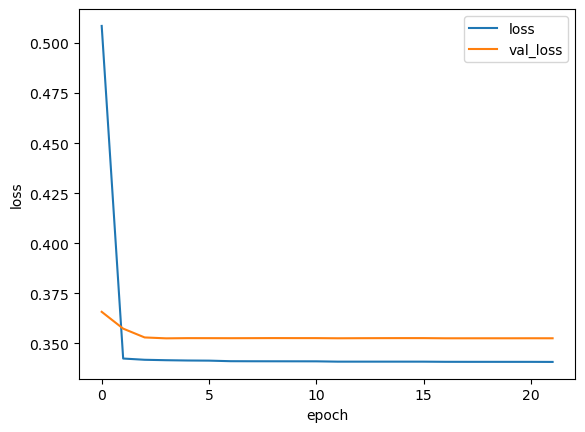

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

train_history = conf.execute_training(
    model, 
    data=train_dataset, 
    plot_history=INTERACTIVE_SESSION
)

In [10]:
# Load best trained model checkpoint
best_model_track = sorted(glob(conf.save_path+'/*.h5'))
if len(best_model_track):
    model.load_weights(best_model_track[0])

# Generate predictions for all images in the test set
val_preds = model.predict(val_dataset[0])

test_preds = model.predict(test_dataset[0])

   1/2010 [..............................] - ETA: 30:08

  13/2010 [..............................] - ETA: 8s   

  25/2010 [..............................] - ETA: 8s

  36/2010 [..............................] - ETA: 8s

  47/2010 [..............................] - ETA: 8s

  58/2010 [..............................] - ETA: 8s

  69/2010 [>.............................] - ETA: 8s

  80/2010 [>.............................] - ETA: 8s

  91/2010 [>.............................] - ETA: 8s

 102/2010 [>.............................] - ETA: 8s

 113/2010 [>.............................] - ETA: 8s

 124/2010 [>.............................] - ETA: 8s

 135/2010 [=>............................] - ETA: 8s

 146/2010 [=>............................] - ETA: 8s

 157/2010 [=>............................] - ETA: 8s

 168/2010 [=>............................] - ETA: 8s

 179/2010 [=>............................] - ETA: 8s

 190/2010 [=>............................] - ETA: 8s

 201/2010 [==>...........................] - ETA: 8s

 212/2010 [==>...........................] - ETA: 8s

 223/2010 [==>...........................] - ETA: 8s

 234/2010 [==>...........................] - ETA: 8s

 245/2010 [==>...........................] - ETA: 8s

 256/2010 [==>...........................] - ETA: 8s

 267/2010 [==>...........................] - ETA: 8s

 278/2010 [===>..........................] - ETA: 7s

 289/2010 [===>..........................] - ETA: 7s

 300/2010 [===>..........................] - ETA: 7s

 311/2010 [===>..........................] - ETA: 7s

 322/2010 [===>..........................] - ETA: 7s

 333/2010 [===>..........................] - ETA: 7s

 344/2010 [====>.........................] - ETA: 7s

 355/2010 [====>.........................] - ETA: 7s

 366/2010 [====>.........................] - ETA: 7s

 377/2010 [====>.........................] - ETA: 7s

 388/2010 [====>.........................] - ETA: 7s

 399/2010 [====>.........................] - ETA: 7s

 410/2010 [=====>........................] - ETA: 7s

 421/2010 [=====>........................] - ETA: 7s

 432/2010 [=====>........................] - ETA: 7s

 443/2010 [=====>........................] - ETA: 7s

 454/2010 [=====>........................] - ETA: 7s

 465/2010 [=====>........................] - ETA: 7s

 476/2010 [======>.......................] - ETA: 7s

 487/2010 [======>.......................] - ETA: 7s

 498/2010 [======>.......................] - ETA: 7s

 509/2010 [======>.......................] - ETA: 6s

 520/2010 [======>.......................] - ETA: 6s

 531/2010 [======>.......................] - ETA: 6s

 542/2010 [=======>......................] - ETA: 6s

 553/2010 [=======>......................] - ETA: 6s

 564/2010 [=======>......................] - ETA: 6s

 575/2010 [=======>......................] - ETA: 6s

 586/2010 [=======>......................] - ETA: 6s

 597/2010 [=======>......................] - ETA: 6s

 608/2010 [========>.....................] - ETA: 6s

 619/2010 [========>.....................] - ETA: 6s

 630/2010 [========>.....................] - ETA: 6s

 641/2010 [========>.....................] - ETA: 6s

 652/2010 [========>.....................] - ETA: 6s

 663/2010 [========>.....................] - ETA: 6s

 674/2010 [=========>....................] - ETA: 6s

 685/2010 [=========>....................] - ETA: 6s

 696/2010 [=========>....................] - ETA: 6s

 707/2010 [=========>....................] - ETA: 6s

 718/2010 [=========>....................] - ETA: 6s

 729/2010 [=========>....................] - ETA: 5s

 740/2010 [==========>...................] - ETA: 5s

 751/2010 [==========>...................] - ETA: 5s

 762/2010 [==========>...................] - ETA: 5s

 773/2010 [==========>...................] - ETA: 5s

 784/2010 [==========>...................] - ETA: 5s

 795/2010 [==========>...................] - ETA: 5s

 806/2010 [===========>..................] - ETA: 5s

 817/2010 [===========>..................] - ETA: 5s

 828/2010 [===========>..................] - ETA: 5s

 839/2010 [===========>..................] - ETA: 5s

 850/2010 [===========>..................] - ETA: 5s

 861/2010 [===========>..................] - ETA: 5s

 872/2010 [============>.................] - ETA: 5s

 883/2010 [============>.................] - ETA: 5s

 894/2010 [============>.................] - ETA: 5s

 905/2010 [============>.................] - ETA: 5s

 916/2010 [============>.................] - ETA: 5s

 927/2010 [============>.................] - ETA: 5s

 938/2010 [=============>................] - ETA: 4s

 949/2010 [=============>................] - ETA: 4s

 960/2010 [=============>................] - ETA: 4s

 971/2010 [=============>................] - ETA: 4s

 982/2010 [=============>................] - ETA: 4s

 993/2010 [=============>................] - ETA: 4s

1004/2010 [=============>................] - ETA: 4s

1015/2010 [==============>...............] - ETA: 4s

1026/2010 [==============>...............] - ETA: 4s

1037/2010 [==============>...............] - ETA: 4s

1048/2010 [==============>...............] - ETA: 4s

1059/2010 [==============>...............] - ETA: 4s

1070/2010 [==============>...............] - ETA: 4s

1081/2010 [===============>..............] - ETA: 4s

1092/2010 [===============>..............] - ETA: 4s

1103/2010 [===============>..............] - ETA: 4s

1114/2010 [===============>..............] - ETA: 4s

1125/2010 [===============>..............] - ETA: 4s

1136/2010 [===============>..............] - ETA: 4s

1147/2010 [================>.............] - ETA: 4s

1158/2010 [================>.............] - ETA: 3s

1169/2010 [================>.............] - ETA: 3s

1180/2010 [================>.............] - ETA: 3s

1191/2010 [================>.............] - ETA: 3s

1202/2010 [================>.............] - ETA: 3s

1213/2010 [=================>............] - ETA: 3s

1224/2010 [=================>............] - ETA: 3s

1235/2010 [=================>............] - ETA: 3s

1246/2010 [=================>............] - ETA: 3s

1257/2010 [=================>............] - ETA: 3s

1268/2010 [=================>............] - ETA: 3s

1279/2010 [==================>...........] - ETA: 3s

1290/2010 [==================>...........] - ETA: 3s

1301/2010 [==================>...........] - ETA: 3s

1312/2010 [==================>...........] - ETA: 3s

1323/2010 [==================>...........] - ETA: 3s

1334/2010 [==================>...........] - ETA: 3s

1345/2010 [===================>..........] - ETA: 3s

1356/2010 [===================>..........] - ETA: 3s

1367/2010 [===================>..........] - ETA: 3s

1378/2010 [===================>..........] - ETA: 2s

1389/2010 [===================>..........] - ETA: 2s

1400/2010 [===================>..........] - ETA: 2s

1411/2010 [====================>.........] - ETA: 2s

1422/2010 [====================>.........] - ETA: 2s

1433/2010 [====================>.........] - ETA: 2s

1444/2010 [====================>.........] - ETA: 2s

1455/2010 [====================>.........] - ETA: 2s

1466/2010 [====================>.........] - ETA: 2s

1477/2010 [=====================>........] - ETA: 2s

1488/2010 [=====================>........] - ETA: 2s

1499/2010 [=====================>........] - ETA: 2s

1510/2010 [=====================>........] - ETA: 2s

1521/2010 [=====================>........] - ETA: 2s

1532/2010 [=====================>........] - ETA: 2s

1543/2010 [======================>.......] - ETA: 2s

1554/2010 [======================>.......] - ETA: 2s

1565/2010 [======================>.......] - ETA: 2s

1576/2010 [======================>.......] - ETA: 2s

1587/2010 [======================>.......] - ETA: 1s

1598/2010 [======================>.......] - ETA: 1s

1609/2010 [=======================>......] - ETA: 1s

1620/2010 [=======================>......] - ETA: 1s

1631/2010 [=======================>......] - ETA: 1s

1642/2010 [=======================>......] - ETA: 1s

1653/2010 [=======================>......] - ETA: 1s

1664/2010 [=======================>......] - ETA: 1s

1675/2010 [========================>.....] - ETA: 1s

1686/2010 [========================>.....] - ETA: 1s

1697/2010 [========================>.....] - ETA: 1s

1708/2010 [========================>.....] - ETA: 1s

1719/2010 [========================>.....] - ETA: 1s

1730/2010 [========================>.....] - ETA: 1s

1741/2010 [========================>.....] - ETA: 1s

1752/2010 [=========================>....] - ETA: 1s

1763/2010 [=========================>....] - ETA: 1s

1774/2010 [=========================>....] - ETA: 1s

1785/2010 [=========================>....] - ETA: 1s

1796/2010 [=========================>....] - ETA: 1s

1807/2010 [=========================>....] - ETA: 0s

1818/2010 [==========================>...] - ETA: 0s

1829/2010 [==========================>...] - ETA: 0s

1840/2010 [==========================>...] - ETA: 0s

1851/2010 [==========================>...] - ETA: 0s

1862/2010 [==========================>...] - ETA: 0s

1873/2010 [==========================>...] - ETA: 0s

1884/2010 [===========================>..] - ETA: 0s

1895/2010 [===========================>..] - ETA: 0s

1906/2010 [===========================>..] - ETA: 0s

1917/2010 [===========================>..] - ETA: 0s

1928/2010 [===========================>..] - ETA: 0s

1939/2010 [===========================>..] - ETA: 0s

1950/2010 [============================>.] - ETA: 0s

1961/2010 [============================>.] - ETA: 0s

1972/2010 [============================>.] - ETA: 0s

1983/2010 [============================>.] - ETA: 0s

1994/2010 [============================>.] - ETA: 0s

2005/2010 [============================>.] - ETA: 0s

2010/2010 [==============================] - ETA: 0s

2010/2010 [==============================] - 11s 5ms/step


   1/2065 [..............................] - ETA: 55s

  15/2065 [..............................] - ETA: 7s 

  29/2065 [..............................] - ETA: 7s

  42/2065 [..............................] - ETA: 7s

  55/2065 [..............................] - ETA: 7s

  68/2065 [..............................] - ETA: 7s

  79/2065 [>.............................] - ETA: 8s

  90/2065 [>.............................] - ETA: 8s

 101/2065 [>.............................] - ETA: 8s

 112/2065 [>.............................] - ETA: 8s

 123/2065 [>.............................] - ETA: 8s

 134/2065 [>.............................] - ETA: 8s

 145/2065 [=>............................] - ETA: 8s

 156/2065 [=>............................] - ETA: 8s

 168/2065 [=>............................] - ETA: 8s

 179/2065 [=>............................] - ETA: 8s

 190/2065 [=>............................] - ETA: 8s

 202/2065 [=>............................] - ETA: 8s

 213/2065 [==>...........................] - ETA: 8s

 224/2065 [==>...........................] - ETA: 8s

 235/2065 [==>...........................] - ETA: 8s

 246/2065 [==>...........................] - ETA: 8s

 257/2065 [==>...........................] - ETA: 8s

 268/2065 [==>...........................] - ETA: 7s

 279/2065 [===>..........................] - ETA: 7s

 290/2065 [===>..........................] - ETA: 7s

 301/2065 [===>..........................] - ETA: 7s

 312/2065 [===>..........................] - ETA: 7s

 323/2065 [===>..........................] - ETA: 7s

 334/2065 [===>..........................] - ETA: 7s

 345/2065 [====>.........................] - ETA: 7s

 356/2065 [====>.........................] - ETA: 7s

 367/2065 [====>.........................] - ETA: 7s

 378/2065 [====>.........................] - ETA: 7s

 390/2065 [====>.........................] - ETA: 7s

 402/2065 [====>.........................] - ETA: 7s

 413/2065 [=====>........................] - ETA: 7s

 424/2065 [=====>........................] - ETA: 7s

 435/2065 [=====>........................] - ETA: 7s

 446/2065 [=====>........................] - ETA: 7s

 457/2065 [=====>........................] - ETA: 7s

 468/2065 [=====>........................] - ETA: 7s

 479/2065 [=====>........................] - ETA: 7s

 490/2065 [======>.......................] - ETA: 7s

 501/2065 [======>.......................] - ETA: 7s

 512/2065 [======>.......................] - ETA: 7s

 523/2065 [======>.......................] - ETA: 7s

 534/2065 [======>.......................] - ETA: 6s

 545/2065 [======>.......................] - ETA: 6s

 556/2065 [=======>......................] - ETA: 6s

 567/2065 [=======>......................] - ETA: 6s

 578/2065 [=======>......................] - ETA: 6s

 590/2065 [=======>......................] - ETA: 6s

 602/2065 [=======>......................] - ETA: 6s

 613/2065 [=======>......................] - ETA: 6s

 624/2065 [========>.....................] - ETA: 6s

 635/2065 [========>.....................] - ETA: 6s

 646/2065 [========>.....................] - ETA: 6s

 657/2065 [========>.....................] - ETA: 6s

 668/2065 [========>.....................] - ETA: 6s

 679/2065 [========>.....................] - ETA: 6s

 690/2065 [=========>....................] - ETA: 6s

 701/2065 [=========>....................] - ETA: 6s

 712/2065 [=========>....................] - ETA: 6s

 723/2065 [=========>....................] - ETA: 6s

 734/2065 [=========>....................] - ETA: 6s

 746/2065 [=========>....................] - ETA: 6s

 757/2065 [=========>....................] - ETA: 5s

 768/2065 [==========>...................] - ETA: 5s

 779/2065 [==========>...................] - ETA: 5s

 791/2065 [==========>...................] - ETA: 5s

 802/2065 [==========>...................] - ETA: 5s

 813/2065 [==========>...................] - ETA: 5s

 824/2065 [==========>...................] - ETA: 5s

 835/2065 [===========>..................] - ETA: 5s

 846/2065 [===========>..................] - ETA: 5s

 857/2065 [===========>..................] - ETA: 5s

 868/2065 [===========>..................] - ETA: 5s

 879/2065 [===========>..................] - ETA: 5s

 890/2065 [===========>..................] - ETA: 5s

 901/2065 [============>.................] - ETA: 5s

 912/2065 [============>.................] - ETA: 5s

 923/2065 [============>.................] - ETA: 5s

 934/2065 [============>.................] - ETA: 5s

 946/2065 [============>.................] - ETA: 5s

 958/2065 [============>.................] - ETA: 5s

 970/2065 [=============>................] - ETA: 5s

 982/2065 [=============>................] - ETA: 4s

 993/2065 [=============>................] - ETA: 4s

1004/2065 [=============>................] - ETA: 4s

1015/2065 [=============>................] - ETA: 4s

1026/2065 [=============>................] - ETA: 4s

1037/2065 [==============>...............] - ETA: 4s

1048/2065 [==============>...............] - ETA: 4s

1059/2065 [==============>...............] - ETA: 4s

1070/2065 [==============>...............] - ETA: 4s

1081/2065 [==============>...............] - ETA: 4s

1092/2065 [==============>...............] - ETA: 4s

1103/2065 [===============>..............] - ETA: 4s

1115/2065 [===============>..............] - ETA: 4s

1126/2065 [===============>..............] - ETA: 4s

1138/2065 [===============>..............] - ETA: 4s

1149/2065 [===============>..............] - ETA: 4s

1160/2065 [===============>..............] - ETA: 4s

1171/2065 [================>.............] - ETA: 4s

1182/2065 [================>.............] - ETA: 4s

1193/2065 [================>.............] - ETA: 4s

1204/2065 [================>.............] - ETA: 3s

1215/2065 [================>.............] - ETA: 3s

1226/2065 [================>.............] - ETA: 3s

1237/2065 [================>.............] - ETA: 3s

1248/2065 [=================>............] - ETA: 3s

1259/2065 [=================>............] - ETA: 3s

1270/2065 [=================>............] - ETA: 3s

1281/2065 [=================>............] - ETA: 3s

1292/2065 [=================>............] - ETA: 3s

1303/2065 [=================>............] - ETA: 3s

1314/2065 [==================>...........] - ETA: 3s

1325/2065 [==================>...........] - ETA: 3s

1336/2065 [==================>...........] - ETA: 3s

1347/2065 [==================>...........] - ETA: 3s

1358/2065 [==================>...........] - ETA: 3s

1369/2065 [==================>...........] - ETA: 3s

1380/2065 [===================>..........] - ETA: 3s

1391/2065 [===================>..........] - ETA: 3s

1402/2065 [===================>..........] - ETA: 3s

1413/2065 [===================>..........] - ETA: 3s

1424/2065 [===================>..........] - ETA: 2s

1435/2065 [===================>..........] - ETA: 2s

1446/2065 [====================>.........] - ETA: 2s

1457/2065 [====================>.........] - ETA: 2s

1468/2065 [====================>.........] - ETA: 2s

1480/2065 [====================>.........] - ETA: 2s

1491/2065 [====================>.........] - ETA: 2s

1503/2065 [====================>.........] - ETA: 2s

1515/2065 [=====================>........] - ETA: 2s

1526/2065 [=====================>........] - ETA: 2s

1537/2065 [=====================>........] - ETA: 2s

1548/2065 [=====================>........] - ETA: 2s

1559/2065 [=====================>........] - ETA: 2s

1570/2065 [=====================>........] - ETA: 2s

1581/2065 [=====================>........] - ETA: 2s

1592/2065 [======================>.......] - ETA: 2s

1603/2065 [======================>.......] - ETA: 2s

1614/2065 [======================>.......] - ETA: 2s

1625/2065 [======================>.......] - ETA: 2s

1636/2065 [======================>.......] - ETA: 1s

1647/2065 [======================>.......] - ETA: 1s

1658/2065 [=======================>......] - ETA: 1s

1669/2065 [=======================>......] - ETA: 1s

1680/2065 [=======================>......] - ETA: 1s

1692/2065 [=======================>......] - ETA: 1s

1703/2065 [=======================>......] - ETA: 1s

1714/2065 [=======================>......] - ETA: 1s

1725/2065 [========================>.....] - ETA: 1s

1736/2065 [========================>.....] - ETA: 1s

1747/2065 [========================>.....] - ETA: 1s

1758/2065 [========================>.....] - ETA: 1s

1769/2065 [========================>.....] - ETA: 1s

1780/2065 [========================>.....] - ETA: 1s

1791/2065 [=========================>....] - ETA: 1s

1802/2065 [=========================>....] - ETA: 1s

1813/2065 [=========================>....] - ETA: 1s

1824/2065 [=========================>....] - ETA: 1s

1836/2065 [=========================>....] - ETA: 1s

1847/2065 [=========================>....] - ETA: 1s

1858/2065 [=========================>....] - ETA: 0s

1870/2065 [==========================>...] - ETA: 0s

1881/2065 [==========================>...] - ETA: 0s

1892/2065 [==========================>...] - ETA: 0s

1903/2065 [==========================>...] - ETA: 0s

1914/2065 [==========================>...] - ETA: 0s

1925/2065 [==========================>...] - ETA: 0s

1936/2065 [===========================>..] - ETA: 0s

1947/2065 [===========================>..] - ETA: 0s

1958/2065 [===========================>..] - ETA: 0s

1969/2065 [===========================>..] - ETA: 0s

1980/2065 [===========================>..] - ETA: 0s

1991/2065 [===========================>..] - ETA: 0s

2002/2065 [============================>.] - ETA: 0s

2013/2065 [============================>.] - ETA: 0s

2024/2065 [============================>.] - ETA: 0s

2035/2065 [============================>.] - ETA: 0s

2046/2065 [============================>.] - ETA: 0s

2057/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - 10s 5ms/step


In [11]:
model.evaluate(x=val_dataset[0],y=val_dataset[1])

   1/2010 [..............................] - ETA: 1:02 - loss: 0.3769 - accuracy: 0.8753

  10/2010 [..............................] - ETA: 11s - loss: 0.3594 - accuracy: 0.8838 

  19/2010 [..............................] - ETA: 11s - loss: 0.3552 - accuracy: 0.8859

  28/2010 [..............................] - ETA: 11s - loss: 0.3522 - accuracy: 0.8873

  37/2010 [..............................] - ETA: 11s - loss: 0.3516 - accuracy: 0.8876

  46/2010 [..............................] - ETA: 11s - loss: 0.3515 - accuracy: 0.8876

  55/2010 [..............................] - ETA: 11s - loss: 0.3507 - accuracy: 0.8880

  64/2010 [..............................] - ETA: 11s - loss: 0.3523 - accuracy: 0.8872

  73/2010 [>.............................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8877

  82/2010 [>.............................] - ETA: 11s - loss: 0.3509 - accuracy: 0.8879

  91/2010 [>.............................] - ETA: 11s - loss: 0.3513 - accuracy: 0.8877

 100/2010 [>.............................] - ETA: 11s - loss: 0.3508 - accuracy: 0.8880

 108/2010 [>.............................] - ETA: 11s - loss: 0.3510 - accuracy: 0.8879

 117/2010 [>.............................] - ETA: 11s - loss: 0.3510 - accuracy: 0.8879

 126/2010 [>.............................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8882

 135/2010 [=>............................] - ETA: 11s - loss: 0.3499 - accuracy: 0.8884

 144/2010 [=>............................] - ETA: 11s - loss: 0.3503 - accuracy: 0.8882

 153/2010 [=>............................] - ETA: 11s - loss: 0.3497 - accuracy: 0.8885

 162/2010 [=>............................] - ETA: 11s - loss: 0.3496 - accuracy: 0.8885

 171/2010 [=>............................] - ETA: 11s - loss: 0.3504 - accuracy: 0.8882

 180/2010 [=>............................] - ETA: 11s - loss: 0.3501 - accuracy: 0.8883

 189/2010 [=>............................] - ETA: 11s - loss: 0.3498 - accuracy: 0.8885

 198/2010 [=>............................] - ETA: 10s - loss: 0.3498 - accuracy: 0.8885

 207/2010 [==>...........................] - ETA: 10s - loss: 0.3502 - accuracy: 0.8883

 216/2010 [==>...........................] - ETA: 10s - loss: 0.3501 - accuracy: 0.8883

 225/2010 [==>...........................] - ETA: 10s - loss: 0.3500 - accuracy: 0.8884

 234/2010 [==>...........................] - ETA: 10s - loss: 0.3504 - accuracy: 0.8882

 243/2010 [==>...........................] - ETA: 10s - loss: 0.3502 - accuracy: 0.8883

 252/2010 [==>...........................] - ETA: 10s - loss: 0.3502 - accuracy: 0.8883

 261/2010 [==>...........................] - ETA: 10s - loss: 0.3506 - accuracy: 0.8881

 270/2010 [===>..........................] - ETA: 10s - loss: 0.3507 - accuracy: 0.8880

 279/2010 [===>..........................] - ETA: 10s - loss: 0.3510 - accuracy: 0.8879

 288/2010 [===>..........................] - ETA: 10s - loss: 0.3512 - accuracy: 0.8878

 297/2010 [===>..........................] - ETA: 10s - loss: 0.3511 - accuracy: 0.8878

 305/2010 [===>..........................] - ETA: 10s - loss: 0.3510 - accuracy: 0.8879

 313/2010 [===>..........................] - ETA: 10s - loss: 0.3511 - accuracy: 0.8878

 322/2010 [===>..........................] - ETA: 10s - loss: 0.3512 - accuracy: 0.8878

 331/2010 [===>..........................] - ETA: 10s - loss: 0.3514 - accuracy: 0.8877

 340/2010 [====>.........................] - ETA: 10s - loss: 0.3515 - accuracy: 0.8876

 349/2010 [====>.........................] - ETA: 10s - loss: 0.3518 - accuracy: 0.8875

 358/2010 [====>.........................] - ETA: 10s - loss: 0.3520 - accuracy: 0.8874

 366/2010 [====>.........................] - ETA: 10s - loss: 0.3521 - accuracy: 0.8874

 375/2010 [====>.........................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8873 

 384/2010 [====>.........................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8873

 393/2010 [====>.........................] - ETA: 9s - loss: 0.3520 - accuracy: 0.8874

 402/2010 [=====>........................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8873

 411/2010 [=====>........................] - ETA: 9s - loss: 0.3520 - accuracy: 0.8874

 419/2010 [=====>........................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8874

 427/2010 [=====>........................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8874

 435/2010 [=====>........................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8873

 444/2010 [=====>........................] - ETA: 9s - loss: 0.3519 - accuracy: 0.8875

 453/2010 [=====>........................] - ETA: 9s - loss: 0.3519 - accuracy: 0.8874

 462/2010 [=====>........................] - ETA: 9s - loss: 0.3521 - accuracy: 0.8874

 471/2010 [======>.......................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8872

 480/2010 [======>.......................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8873

 489/2010 [======>.......................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8873

 498/2010 [======>.......................] - ETA: 9s - loss: 0.3522 - accuracy: 0.8873

 507/2010 [======>.......................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8873

 516/2010 [======>.......................] - ETA: 9s - loss: 0.3523 - accuracy: 0.8873

 525/2010 [======>.......................] - ETA: 9s - loss: 0.3524 - accuracy: 0.8872

 534/2010 [======>.......................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8873

 543/2010 [=======>......................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8873

 552/2010 [=======>......................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8873

 561/2010 [=======>......................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8873

 570/2010 [=======>......................] - ETA: 8s - loss: 0.3521 - accuracy: 0.8874

 579/2010 [=======>......................] - ETA: 8s - loss: 0.3519 - accuracy: 0.8874

 588/2010 [=======>......................] - ETA: 8s - loss: 0.3521 - accuracy: 0.8874

 597/2010 [=======>......................] - ETA: 8s - loss: 0.3521 - accuracy: 0.8874

 606/2010 [========>.....................] - ETA: 8s - loss: 0.3520 - accuracy: 0.8874

 615/2010 [========>.....................] - ETA: 8s - loss: 0.3522 - accuracy: 0.8873

 624/2010 [========>.....................] - ETA: 8s - loss: 0.3523 - accuracy: 0.8873

 633/2010 [========>.....................] - ETA: 8s - loss: 0.3523 - accuracy: 0.8873

 642/2010 [========>.....................] - ETA: 8s - loss: 0.3524 - accuracy: 0.8872

 651/2010 [========>.....................] - ETA: 8s - loss: 0.3524 - accuracy: 0.8872

 660/2010 [========>.....................] - ETA: 8s - loss: 0.3524 - accuracy: 0.8872

 669/2010 [========>.....................] - ETA: 8s - loss: 0.3524 - accuracy: 0.8872

 678/2010 [=========>....................] - ETA: 8s - loss: 0.3523 - accuracy: 0.8872

 687/2010 [=========>....................] - ETA: 8s - loss: 0.3523 - accuracy: 0.8872

 696/2010 [=========>....................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8873

 705/2010 [=========>....................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 714/2010 [=========>....................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 723/2010 [=========>....................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 732/2010 [=========>....................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 741/2010 [==========>...................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 750/2010 [==========>...................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 759/2010 [==========>...................] - ETA: 7s - loss: 0.3520 - accuracy: 0.8874

 768/2010 [==========>...................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 777/2010 [==========>...................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 786/2010 [==========>...................] - ETA: 7s - loss: 0.3523 - accuracy: 0.8873

 795/2010 [==========>...................] - ETA: 7s - loss: 0.3522 - accuracy: 0.8873

 804/2010 [===========>..................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8873

 813/2010 [===========>..................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8874

 822/2010 [===========>..................] - ETA: 7s - loss: 0.3520 - accuracy: 0.8874

 831/2010 [===========>..................] - ETA: 7s - loss: 0.3520 - accuracy: 0.8874

 840/2010 [===========>..................] - ETA: 7s - loss: 0.3519 - accuracy: 0.8874

 849/2010 [===========>..................] - ETA: 7s - loss: 0.3519 - accuracy: 0.8874

 857/2010 [===========>..................] - ETA: 7s - loss: 0.3521 - accuracy: 0.8874

 865/2010 [===========>..................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 873/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 882/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 890/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 899/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 908/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 917/2010 [============>.................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 926/2010 [============>.................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 934/2010 [============>.................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 943/2010 [=============>................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 952/2010 [=============>................] - ETA: 6s - loss: 0.3521 - accuracy: 0.8873

 961/2010 [=============>................] - ETA: 6s - loss: 0.3522 - accuracy: 0.8873

 970/2010 [=============>................] - ETA: 6s - loss: 0.3523 - accuracy: 0.8873

 979/2010 [=============>................] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

 988/2010 [=============>................] - ETA: 6s - loss: 0.3524 - accuracy: 0.8872

 997/2010 [=============>................] - ETA: 6s - loss: 0.3524 - accuracy: 0.8872

1006/2010 [==============>...............] - ETA: 6s - loss: 0.3525 - accuracy: 0.8872

1015/2010 [==============>...............] - ETA: 6s - loss: 0.3524 - accuracy: 0.8872

1024/2010 [==============>...............] - ETA: 6s - loss: 0.3523 - accuracy: 0.8872

1033/2010 [==============>...............] - ETA: 5s - loss: 0.3524 - accuracy: 0.8872

1042/2010 [==============>...............] - ETA: 5s - loss: 0.3524 - accuracy: 0.8872

1051/2010 [==============>...............] - ETA: 5s - loss: 0.3524 - accuracy: 0.8872

1060/2010 [==============>...............] - ETA: 5s - loss: 0.3524 - accuracy: 0.8872

1068/2010 [==============>...............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1077/2010 [===============>..............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8873

1086/2010 [===============>..............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8873

1095/2010 [===============>..............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8873

1104/2010 [===============>..............] - ETA: 5s - loss: 0.3522 - accuracy: 0.8873

1113/2010 [===============>..............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1122/2010 [===============>..............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8873

1131/2010 [===============>..............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1140/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8873

1149/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1158/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8873

1167/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1176/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8873

1185/2010 [================>.............] - ETA: 5s - loss: 0.3523 - accuracy: 0.8872

1194/2010 [================>.............] - ETA: 4s - loss: 0.3523 - accuracy: 0.8873

1203/2010 [================>.............] - ETA: 4s - loss: 0.3523 - accuracy: 0.8872

1212/2010 [=================>............] - ETA: 4s - loss: 0.3524 - accuracy: 0.8872

1221/2010 [=================>............] - ETA: 4s - loss: 0.3524 - accuracy: 0.8872

1230/2010 [=================>............] - ETA: 4s - loss: 0.3525 - accuracy: 0.8872

1239/2010 [=================>............] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1248/2010 [=================>............] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1257/2010 [=================>............] - ETA: 4s - loss: 0.3526 - accuracy: 0.8871

1266/2010 [=================>............] - ETA: 4s - loss: 0.3526 - accuracy: 0.8871

1275/2010 [==================>...........] - ETA: 4s - loss: 0.3526 - accuracy: 0.8871

1284/2010 [==================>...........] - ETA: 4s - loss: 0.3526 - accuracy: 0.8871

1293/2010 [==================>...........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1302/2010 [==================>...........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1311/2010 [==================>...........] - ETA: 4s - loss: 0.3526 - accuracy: 0.8871

1320/2010 [==================>...........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1328/2010 [==================>...........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1337/2010 [==================>...........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8871

1346/2010 [===================>..........] - ETA: 4s - loss: 0.3525 - accuracy: 0.8872

1355/2010 [===================>..........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8871

1364/2010 [===================>..........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8871

1373/2010 [===================>..........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8872

1382/2010 [===================>..........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8872

1391/2010 [===================>..........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1400/2010 [===================>..........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1409/2010 [====================>.........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8872

1418/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1427/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1436/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1445/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1454/2010 [====================>.........] - ETA: 3s - loss: 0.3525 - accuracy: 0.8872

1463/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1471/2010 [====================>.........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1480/2010 [=====================>........] - ETA: 3s - loss: 0.3524 - accuracy: 0.8872

1489/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1498/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8873

1507/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8872

1516/2010 [=====================>........] - ETA: 3s - loss: 0.3523 - accuracy: 0.8873

1525/2010 [=====================>........] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1534/2010 [=====================>........] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1543/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1552/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1561/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8872

1570/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1579/2010 [======================>.......] - ETA: 2s - loss: 0.3522 - accuracy: 0.8873

1588/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8873

1597/2010 [======================>.......] - ETA: 2s - loss: 0.3523 - accuracy: 0.8872

1606/2010 [======================>.......] - ETA: 2s - loss: 0.3524 - accuracy: 0.8872

1615/2010 [=======================>......] - ETA: 2s - loss: 0.3524 - accuracy: 0.8872

1624/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1633/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1642/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1651/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1660/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1669/2010 [=======================>......] - ETA: 2s - loss: 0.3525 - accuracy: 0.8872

1678/2010 [========================>.....] - ETA: 2s - loss: 0.3525 - accuracy: 0.8871

1687/2010 [========================>.....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1696/2010 [========================>.....] - ETA: 1s - loss: 0.3527 - accuracy: 0.8871

1705/2010 [========================>.....] - ETA: 1s - loss: 0.3527 - accuracy: 0.8871

1714/2010 [========================>.....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1723/2010 [========================>.....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1732/2010 [========================>.....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1741/2010 [========================>.....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1750/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1759/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1768/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1777/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1786/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1795/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1804/2010 [=========================>....] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1813/2010 [==========================>...] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1822/2010 [==========================>...] - ETA: 1s - loss: 0.3526 - accuracy: 0.8871

1831/2010 [==========================>...] - ETA: 1s - loss: 0.3525 - accuracy: 0.8871

1840/2010 [==========================>...] - ETA: 1s - loss: 0.3524 - accuracy: 0.8872

1849/2010 [==========================>...] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1858/2010 [==========================>...] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1867/2010 [==========================>...] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1876/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1885/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1894/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1903/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1912/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1921/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1930/2010 [===========================>..] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1939/2010 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8872

1948/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1957/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1966/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1975/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1984/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8872

1993/2010 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8871

2002/2010 [============================>.] - ETA: 0s - loss: 0.3526 - accuracy: 0.8871

2010/2010 [==============================] - 12s 6ms/step - loss: 0.3525 - accuracy: 0.8871


[0.35252124071121216, 0.8871469497680664]

In [12]:
model.evaluate(x=test_dataset[0],y=test_dataset[1])

   1/2065 [..............................] - ETA: 1:00 - loss: 0.3179 - accuracy: 0.9040

  11/2065 [..............................] - ETA: 11s - loss: 0.3363 - accuracy: 0.8950 

  20/2065 [..............................] - ETA: 11s - loss: 0.3384 - accuracy: 0.8940

  29/2065 [..............................] - ETA: 11s - loss: 0.3349 - accuracy: 0.8957

  38/2065 [..............................] - ETA: 11s - loss: 0.3369 - accuracy: 0.8947

  47/2065 [..............................] - ETA: 11s - loss: 0.3364 - accuracy: 0.8950

  56/2065 [..............................] - ETA: 11s - loss: 0.3368 - accuracy: 0.8948

  65/2065 [..............................] - ETA: 11s - loss: 0.3374 - accuracy: 0.8945

  74/2065 [>.............................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8946

  82/2065 [>.............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

  91/2065 [>.............................] - ETA: 11s - loss: 0.3386 - accuracy: 0.8939

 100/2065 [>.............................] - ETA: 11s - loss: 0.3376 - accuracy: 0.8944

 109/2065 [>.............................] - ETA: 11s - loss: 0.3381 - accuracy: 0.8942

 118/2065 [>.............................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8946

 127/2065 [>.............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

 136/2065 [>.............................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8946

 145/2065 [=>............................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8947

 154/2065 [=>............................] - ETA: 11s - loss: 0.3374 - accuracy: 0.8945

 163/2065 [=>............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

 172/2065 [=>............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

 181/2065 [=>............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

 190/2065 [=>............................] - ETA: 11s - loss: 0.3373 - accuracy: 0.8945

 199/2065 [=>............................] - ETA: 11s - loss: 0.3375 - accuracy: 0.8944

 207/2065 [==>...........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8946

 216/2065 [==>...........................] - ETA: 11s - loss: 0.3371 - accuracy: 0.8946

 225/2065 [==>...........................] - ETA: 11s - loss: 0.3370 - accuracy: 0.8947

 234/2065 [==>...........................] - ETA: 11s - loss: 0.3364 - accuracy: 0.8950

 243/2065 [==>...........................] - ETA: 11s - loss: 0.3368 - accuracy: 0.8948

 252/2065 [==>...........................] - ETA: 11s - loss: 0.3369 - accuracy: 0.8947

 261/2065 [==>...........................] - ETA: 11s - loss: 0.3372 - accuracy: 0.8946

 270/2065 [==>...........................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8944

 279/2065 [===>..........................] - ETA: 10s - loss: 0.3378 - accuracy: 0.8943

 288/2065 [===>..........................] - ETA: 10s - loss: 0.3379 - accuracy: 0.8942

 297/2065 [===>..........................] - ETA: 10s - loss: 0.3382 - accuracy: 0.8941

 306/2065 [===>..........................] - ETA: 10s - loss: 0.3381 - accuracy: 0.8941

 315/2065 [===>..........................] - ETA: 10s - loss: 0.3380 - accuracy: 0.8942

 324/2065 [===>..........................] - ETA: 10s - loss: 0.3379 - accuracy: 0.8942

 333/2065 [===>..........................] - ETA: 10s - loss: 0.3378 - accuracy: 0.8943

 342/2065 [===>..........................] - ETA: 10s - loss: 0.3379 - accuracy: 0.8942

 351/2065 [====>.........................] - ETA: 10s - loss: 0.3376 - accuracy: 0.8944

 360/2065 [====>.........................] - ETA: 10s - loss: 0.3378 - accuracy: 0.8943

 369/2065 [====>.........................] - ETA: 10s - loss: 0.3377 - accuracy: 0.8943

 378/2065 [====>.........................] - ETA: 10s - loss: 0.3376 - accuracy: 0.8944

 387/2065 [====>.........................] - ETA: 10s - loss: 0.3375 - accuracy: 0.8944

 396/2065 [====>.........................] - ETA: 10s - loss: 0.3377 - accuracy: 0.8943

 405/2065 [====>.........................] - ETA: 10s - loss: 0.3378 - accuracy: 0.8943

 414/2065 [=====>........................] - ETA: 10s - loss: 0.3379 - accuracy: 0.8942

 423/2065 [=====>........................] - ETA: 10s - loss: 0.3380 - accuracy: 0.8942

 432/2065 [=====>........................] - ETA: 9s - loss: 0.3381 - accuracy: 0.8941 

 441/2065 [=====>........................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8942

 450/2065 [=====>........................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8943

 459/2065 [=====>........................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8943

 468/2065 [=====>........................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8943

 477/2065 [=====>........................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8943

 486/2065 [======>.......................] - ETA: 9s - loss: 0.3378 - accuracy: 0.8943

 495/2065 [======>.......................] - ETA: 9s - loss: 0.3380 - accuracy: 0.8942

 504/2065 [======>.......................] - ETA: 9s - loss: 0.3380 - accuracy: 0.8942

 513/2065 [======>.......................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8942

 522/2065 [======>.......................] - ETA: 9s - loss: 0.3379 - accuracy: 0.8942

 531/2065 [======>.......................] - ETA: 9s - loss: 0.3380 - accuracy: 0.8942

 540/2065 [======>.......................] - ETA: 9s - loss: 0.3381 - accuracy: 0.8941

 548/2065 [======>.......................] - ETA: 9s - loss: 0.3381 - accuracy: 0.8941

 557/2065 [=======>......................] - ETA: 9s - loss: 0.3381 - accuracy: 0.8941

 566/2065 [=======>......................] - ETA: 9s - loss: 0.3381 - accuracy: 0.8941

 575/2065 [=======>......................] - ETA: 9s - loss: 0.3380 - accuracy: 0.8942

 584/2065 [=======>......................] - ETA: 9s - loss: 0.3380 - accuracy: 0.8942

 593/2065 [=======>......................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8942

 602/2065 [=======>......................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 611/2065 [=======>......................] - ETA: 8s - loss: 0.3382 - accuracy: 0.8941

 620/2065 [========>.....................] - ETA: 8s - loss: 0.3382 - accuracy: 0.8941

 628/2065 [========>.....................] - ETA: 8s - loss: 0.3382 - accuracy: 0.8941

 637/2065 [========>.....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 646/2065 [========>.....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 655/2065 [========>.....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 664/2065 [========>.....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 673/2065 [========>.....................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8942

 682/2065 [========>.....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8942

 691/2065 [=========>....................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8942

 700/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8942

 709/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8942

 718/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8942

 727/2065 [=========>....................] - ETA: 8s - loss: 0.3379 - accuracy: 0.8942

 736/2065 [=========>....................] - ETA: 8s - loss: 0.3380 - accuracy: 0.8942

 745/2065 [=========>....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 754/2065 [=========>....................] - ETA: 8s - loss: 0.3381 - accuracy: 0.8941

 763/2065 [==========>...................] - ETA: 7s - loss: 0.3381 - accuracy: 0.8941

 772/2065 [==========>...................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8942

 781/2065 [==========>...................] - ETA: 7s - loss: 0.3381 - accuracy: 0.8942

 790/2065 [==========>...................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8942

 798/2065 [==========>...................] - ETA: 7s - loss: 0.3381 - accuracy: 0.8941

 807/2065 [==========>...................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8942

 816/2065 [==========>...................] - ETA: 7s - loss: 0.3379 - accuracy: 0.8942

 825/2065 [==========>...................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8942

 834/2065 [===========>..................] - ETA: 7s - loss: 0.3379 - accuracy: 0.8942

 843/2065 [===========>..................] - ETA: 7s - loss: 0.3379 - accuracy: 0.8942

 852/2065 [===========>..................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8943

 861/2065 [===========>..................] - ETA: 7s - loss: 0.3377 - accuracy: 0.8943

 870/2065 [===========>..................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8943

 878/2065 [===========>..................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8943

 886/2065 [===========>..................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8943

 895/2065 [============>.................] - ETA: 7s - loss: 0.3378 - accuracy: 0.8943

 904/2065 [============>.................] - ETA: 7s - loss: 0.3379 - accuracy: 0.8942

 913/2065 [============>.................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8942

 922/2065 [============>.................] - ETA: 7s - loss: 0.3381 - accuracy: 0.8941

 931/2065 [============>.................] - ETA: 6s - loss: 0.3380 - accuracy: 0.8942

 940/2065 [============>.................] - ETA: 6s - loss: 0.3380 - accuracy: 0.8942

 949/2065 [============>.................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 958/2065 [============>.................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 967/2065 [=============>................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 976/2065 [=============>................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 985/2065 [=============>................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 994/2065 [=============>................] - ETA: 6s - loss: 0.3378 - accuracy: 0.8943

1003/2065 [=============>................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

1012/2065 [=============>................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

1020/2065 [=============>................] - ETA: 6s - loss: 0.3380 - accuracy: 0.8942

1029/2065 [=============>................] - ETA: 6s - loss: 0.3380 - accuracy: 0.8942

1038/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

1047/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

1056/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

1065/2065 [==============>...............] - ETA: 6s - loss: 0.3378 - accuracy: 0.8943

1074/2065 [==============>...............] - ETA: 6s - loss: 0.3378 - accuracy: 0.8943

1083/2065 [==============>...............] - ETA: 6s - loss: 0.3379 - accuracy: 0.8943

1092/2065 [==============>...............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1101/2065 [==============>...............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1110/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1119/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1128/2065 [===============>..............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1137/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1146/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1155/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1164/2065 [===============>..............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1173/2065 [================>.............] - ETA: 5s - loss: 0.3378 - accuracy: 0.8943

1182/2065 [================>.............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1191/2065 [================>.............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1200/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942

1209/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942

1218/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942

1227/2065 [================>.............] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942

1236/2065 [================>.............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1245/2065 [=================>............] - ETA: 5s - loss: 0.3379 - accuracy: 0.8942

1254/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1262/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1271/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1280/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1289/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1298/2065 [=================>............] - ETA: 4s - loss: 0.3380 - accuracy: 0.8942

1307/2065 [=================>............] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1316/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1325/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1334/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1343/2065 [==================>...........] - ETA: 4s - loss: 0.3378 - accuracy: 0.8943

1352/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1361/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1370/2065 [==================>...........] - ETA: 4s - loss: 0.3379 - accuracy: 0.8942

1379/2065 [===================>..........] - ETA: 4s - loss: 0.3380 - accuracy: 0.8942

1388/2065 [===================>..........] - ETA: 4s - loss: 0.3380 - accuracy: 0.8942

1397/2065 [===================>..........] - ETA: 4s - loss: 0.3380 - accuracy: 0.8942

1406/2065 [===================>..........] - ETA: 4s - loss: 0.3380 - accuracy: 0.8942

1415/2065 [===================>..........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8941

1424/2065 [===================>..........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8941

1433/2065 [===================>..........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8941

1442/2065 [===================>..........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1451/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1460/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1468/2065 [====================>.........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1477/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8942

1486/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8942

1495/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8942

1504/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8942

1513/2065 [====================>.........] - ETA: 3s - loss: 0.3379 - accuracy: 0.8942

1522/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1531/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1540/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1549/2065 [=====================>........] - ETA: 3s - loss: 0.3380 - accuracy: 0.8942

1558/2065 [=====================>........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8941

1567/2065 [=====================>........] - ETA: 3s - loss: 0.3381 - accuracy: 0.8941

1576/2065 [=====================>........] - ETA: 2s - loss: 0.3381 - accuracy: 0.8941

1585/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8941

1594/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8941

1603/2065 [======================>.......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8941

1612/2065 [======================>.......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1621/2065 [======================>.......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1630/2065 [======================>.......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1639/2065 [======================>.......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1648/2065 [======================>.......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1656/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1665/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1674/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1683/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1692/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1701/2065 [=======================>......] - ETA: 2s - loss: 0.3381 - accuracy: 0.8941

1710/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1719/2065 [=======================>......] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1728/2065 [========================>.....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1737/2065 [========================>.....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8941

1745/2065 [========================>.....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8941

1754/2065 [========================>.....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8941

1763/2065 [========================>.....] - ETA: 1s - loss: 0.3382 - accuracy: 0.8941

1772/2065 [========================>.....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8941

1781/2065 [========================>.....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1790/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1798/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1807/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1816/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1825/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1834/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1843/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1852/2065 [=========================>....] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1861/2065 [==========================>...] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1870/2065 [==========================>...] - ETA: 1s - loss: 0.3383 - accuracy: 0.8940

1879/2065 [==========================>...] - ETA: 1s - loss: 0.3384 - accuracy: 0.8940

1888/2065 [==========================>...] - ETA: 1s - loss: 0.3384 - accuracy: 0.8940

1897/2065 [==========================>...] - ETA: 1s - loss: 0.3384 - accuracy: 0.8940

1906/2065 [==========================>...] - ETA: 0s - loss: 0.3384 - accuracy: 0.8940

1915/2065 [==========================>...] - ETA: 0s - loss: 0.3384 - accuracy: 0.8940

1923/2065 [==========================>...] - ETA: 0s - loss: 0.3384 - accuracy: 0.8940

1932/2065 [===========================>..] - ETA: 0s - loss: 0.3384 - accuracy: 0.8940

1941/2065 [===========================>..] - ETA: 0s - loss: 0.3384 - accuracy: 0.8940

1950/2065 [===========================>..] - ETA: 0s - loss: 0.3385 - accuracy: 0.8940

1959/2065 [===========================>..] - ETA: 0s - loss: 0.3385 - accuracy: 0.8940

1968/2065 [===========================>..] - ETA: 0s - loss: 0.3385 - accuracy: 0.8939

1976/2065 [===========================>..] - ETA: 0s - loss: 0.3385 - accuracy: 0.8939

1985/2065 [===========================>..] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

1994/2065 [===========================>..] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2003/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2012/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2021/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2029/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2038/2065 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8939

2047/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2056/2065 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2065/2065 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

2065/2065 [==============================] - 13s 6ms/step - loss: 0.3386 - accuracy: 0.8939


[0.33859652280807495, 0.8938887715339661]

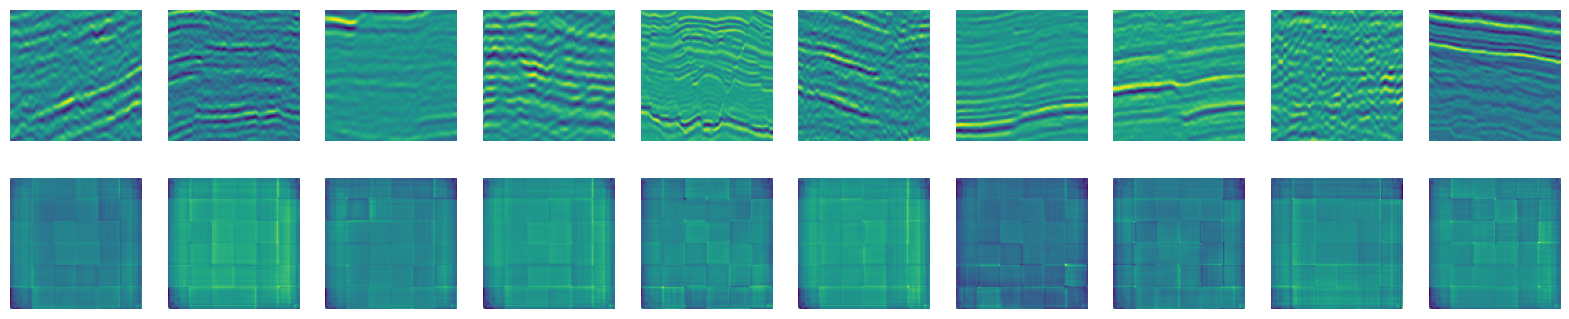

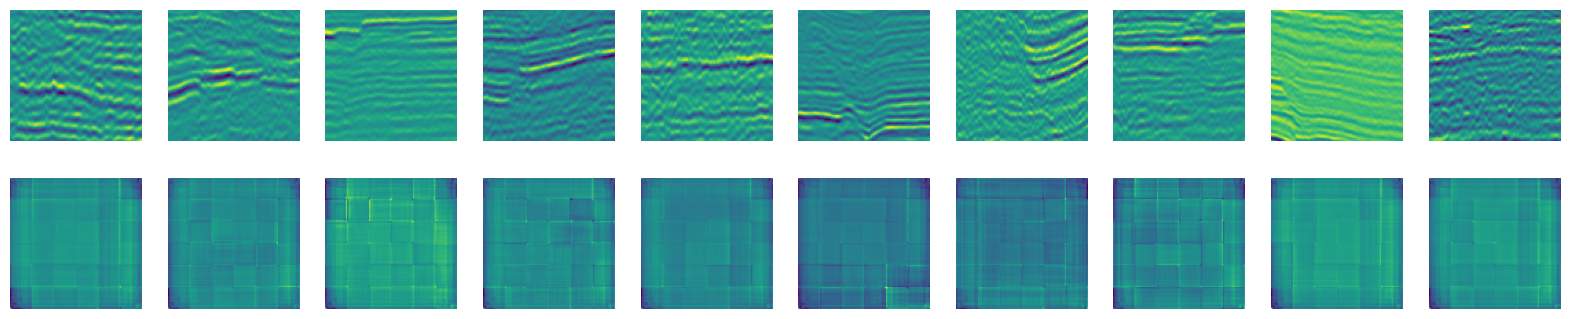

In [13]:
if INTERACTIVE_SESSION:
    display_sample_images(val_dataset[0], val_preds, conf.img_shape)
    display_sample_images(test_dataset[0], test_preds, conf.img_shape)